In [383]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
from sqlalchemy.engine import URL
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import spearmanr
from statsmodels.nonparametric.smoothers_lowess import lowess
import unicodedata as ud
from matplotlib.ticker import FuncFormatter
import textwrap
import statsmodels.formula.api as smf


# Análise Exploratória

## Conectando com o Banco de Dados

In [7]:
load_dotenv()

HOST = os.getenv("PGHOST")
PORT = os.getenv("PGPORT")
DB   = os.getenv("PGDATABASE")
USR  = os.getenv("PGUSER")
PWD  = os.getenv("PGPASSWORD")


In [8]:
# 1) Caminho .env local
ENV_PATH = Path(r"C:\Users\cicer\Documents\Case Técnico Paipe\Análise Exploratória\.env")
print("Arquivo .env existe?", ENV_PATH.exists(), "\nCaminho:", ENV_PATH)

# 2) Carrega o .env
load_dotenv(dotenv_path=ENV_PATH, override=True)

# 3) Confere o que foi lido
cfg = {k: os.getenv(k) for k in ["PGHOST", "PGPORT", "PGDATABASE", "PGUSER"]}
print(cfg, "| PGPASSWORD set?", bool(os.getenv("PGPASSWORD")))


Arquivo .env existe? True 
Caminho: C:\Users\cicer\Documents\Case Técnico Paipe\Análise Exploratória\.env
{'PGHOST': 'localhost', 'PGPORT': '5432', 'PGDATABASE': 'PaipeTech', 'PGUSER': 'postgres'} | PGPASSWORD set? True


In [9]:
HOST = os.getenv("PGHOST", "localhost")
PORT = int(os.getenv("PGPORT") or 5432)
DB   = os.getenv("PGDATABASE")
USR  = os.getenv("PGUSER")
PWD  = os.getenv("PGPASSWORD")

url = URL.create(
    "postgresql+psycopg2",
    username=USR,
    password=PWD,   
    host=HOST,
    port=PORT,
    database=DB,
)

engine = create_engine(url, pool_pre_ping=True)

# teste rápido
with engine.begin() as conn:
    print("DB atual:", conn.execute(text("SELECT current_database()")).scalar())
    print("Versão:",  conn.execute(text("SELECT version()")).scalar().splitlines()[0])


DB atual: PaipeTech
Versão: PostgreSQL 18.0 on x86_64-windows, compiled by msvc-19.44.35215, 64-bit


In [10]:
df = pd.read_sql(text("SELECT * FROM public.df_train"), engine)

## Entendendo panorâma geral dos dados

In [ ]:
df.head()

In [45]:
len(df)

325260

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325260 entries, 0 to 325259
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           325260 non-null  int64  
 1   type                         325260 non-null  object 
 2   region                       177206 non-null  object 
 3   municipalitycode             325260 non-null  int64  
 4   prefecture                   325260 non-null  object 
 5   municipality                 325260 non-null  object 
 6   districtname                 325053 non-null  object 
 7   neareststation               323913 non-null  object 
 8   timetoneareststation         317002 non-null  object 
 9   mintimetoneareststation      317002 non-null  float64
 10  maxtimetoneareststation      316879 non-null  float64
 11  floorplan                    142674 non-null  object 
 12  area                         325260 non-null  int64  
 13 

In [53]:
df.describe()

,id,municipalitycode,mintimetoneareststation,maxtimetoneareststation,area,areaisgreaterflag,unitprice,pricepertsubo,frontage,totalfloorarea,totalfloorareaisgreaterflag,buildingyear,prewarbuilding,breadth,coverageratio,floorarearatio,year,quarter,tradeprice
count,325260.000000,325260.000000,317002.000000,316879.000000,325260.000000,325260.000000,6.358500e+04,6.358500e+04,162145.000000,109005.000000,325260.000000,251512.000000,325260.000000,173966.000000,320607.000000,320607.000000,325260.000000,325260.000000,3.252600e+05
mean,162645.500000,13139.795911,10.192103,11.116758,117.171663,0.003573,4.258723e+05,1.407508e+06,9.629928,172.834136,0.003013,1997.914541,0.000759,6.247910,62.148518,265.552093,2012.583173,2.499809,6.615418e+07
std,93894.618616,46.104492,7.987870,11.617750,204.300075,0.059664,4.760351e+05,1.571122e+06,6.610824,268.194642,0.054808,14.109241,0.027547,4.874636,13.133023,159.670929,3.903713,1.118794,3.245445e+08
min,16.000000,13101.000000,0.000000,0.000000,10.000000,0.000000,4.000000e+00,1.300000e+01,0.500000,10.000000,0.000000,1945.000000,0.000000,1.000000,30.000000,50.000000,2005.000000,1.000000,1.000000e+03
25%,81330.750000,13110.000000,5.000000,5.000000,50.000000,0.000000,2.000000e+05,6.800000e+05,5.900000,85.000000,0.000000,1988.000000,0.000000,4.000000,60.000000,150.000000,2009.000000,1.000000,2.100000e+07
50%,162645.500000,13117.000000,8.000000,8.000000,70.000000,0.000000,3.400000e+05,1.100000e+06,8.000000,95.000000,0.000000,2001.000000,0.000000,5.000000,60.000000,200.000000,2013.000000,3.000000,3.500000e+07
75%,243960.250000,13201.000000,13.000000,13.000000,115.000000,0.000000,5.400000e+05,1.800000e+06,11.400000,120.000000,0.000000,2009.000000,0.000000,6.000000,80.000000,300.000000,2016.000000,3.000000,5.400000e+07
max,325275.000000,13421.000000,120.000000,120.000000,5000.000000,1.000000,2.000000e+07,6.600000e+07,50.000000,2000.000000,1.000000,2020.000000,1.000000,85.000000,80.000000,1200.000000,2019.000000,4.000000,6.100000e+10


In [49]:
df.isna().sum()

id                                  0
type                                0
region                         148054
municipalitycode                    0
prefecture                          0
municipality                        0
districtname                      207
neareststation                   1347
timetoneareststation             8258
mintimetoneareststation          8258
maxtimetoneareststation          8381
floorplan                      182586
area                                0
areaisgreaterflag                   0
unitprice                      261675
pricepertsubo                  261675
landshape                      148372
frontage                       163115
frontageisgreaterflag               0
totalfloorarea                 216255
totalfloorareaisgreaterflag         0
buildingyear                    73748
prewarbuilding                      0
structure                       70510
use                             78223
purpose                        199059
direction   

## Explorando variáveis

Geralmente não é possível explorar cada uma das variáveis pois temos muitas features. Nesse caso, escolhi explorar cada uma, pois temos poucas colunas e não tinha um time de negócios para dar apoio em possíveis dúvidas, então, é muito importante entender bem a base de dados.

In [64]:
df.head(2)

,id,type,region,municipalitycode,prefecture,municipality,districtname,neareststation,timetoneareststation,mintimetoneareststation,maxtimetoneareststation,floorplan,area,areaisgreaterflag,unitprice,pricepertsubo,landshape,frontage,frontageisgreaterflag,totalfloorarea,totalfloorareaisgreaterflag,buildingyear,prewarbuilding,structure,use,purpose,direction,classification,breadth,cityplanning,coverageratio,floorarearatio,period,year,quarter,renovation,remarks,tradeprice
0,16,"Pre-owned Condominiums, etc.",None,13103,Tokyo,Minato Ward,Kaigan,Takeshiba,1,1.0,1.0,1K,35,0,NaN,NaN,None,NaN,False,NaN,0,1979.0,0,SRC,House,None,None,None,NaN,Quasi-industrial Zone,60.0,400.0,1st quarter 2011,2011,1,Done,None,24000000.0
1,17,Residential Land(Land and Building),Residential Area,13120,Tokyo,Nerima Ward,Nishiki,Kamiitabashi,15,15.0,15.0,None,110,0,NaN,NaN,Semi-rectangular Shaped,12.0,False,105.0,0,2013.0,0,W,House,None,East,Private Road,4.0,Category I Exclusively Low-story Residential Zone,60.0,200.0,3rd quarter 2013,2013,3,None,Dealings including private road,51000000.0


In [67]:
df.type.unique()

array(['Pre-owned Condominiums, etc.',
       'Residential Land(Land and Building)',
       'Residential Land(Land Only)', 'Forest Land', 'Agricultural Land'],
      dtype=object)

In [69]:
df.region.unique()

array([None, 'Residential Area', 'Commercial Area', 'Industrial Area',
       'Potential Residential Area'], dtype=object)

In [73]:
len(df.municipalitycode.unique())

59

In [75]:
df.prefecture.unique() #Provavelmente variável irrelevante para o modelo

array(['Tokyo'], dtype=object)

In [79]:
len(df.municipality.unique()) #Nome da cidade, seria a mesma coisa que o código. Usar apenas uma das duas variáveis, dando preferência para o código

59

In [84]:
len(df.districtname.unique())

1446

In [88]:
len(df.neareststation.unique()) #Provavelmente uma variável irrelevante para o modelo, faz mais sentido utilizar a variável timetoneareststation

657

In [92]:
df.timetoneareststation.value_counts() #Ajustar valores da feature, tratar sintaxe e faixas de tempo.

timetoneareststation
6               26790
4               24404
8               24179
5               23191
9               22004
7               20267
3               19932
11              17291
10              17012
2               13492
13              12298
14              11504
12              10358
15               9855
30-60minutes     8800
16               8702
1                8203
18               6586
19               5565
20               4252
21               3645
23               3228
25               2362
24               2351
17               1958
26               1816
28               1706
0                1422
29               1374
1H-1H30          1190
22                663
27                252
1H30-2H           227
2H-               123
Name: count, dtype: int64

In [94]:
df.mintimetoneareststation.unique()

array([  1.,  15.,  60.,  16.,   6.,  10.,  11.,  14.,  21.,   7.,   9.,
         5.,   4.,  13.,  18.,   8.,  22.,  nan,  23.,  24.,  19.,  30.,
        12.,  17.,   3.,   2.,  28.,  20.,  26.,  29.,   0.,  25.,  27.,
        90., 120.])

In [96]:
df.maxtimetoneareststation.unique()

array([  1.,  15.,  90.,  16.,   6.,  10.,  11.,  14.,  21.,   7.,   9.,
         5.,   4.,  13.,  18.,   8.,  22.,  nan,  23.,  24.,  19.,  60.,
        12.,  17.,   3.,   2.,  28.,  20.,  26.,  29.,   0.,  25.,  27.,
       120.])

In [98]:
df.floorplan.unique()

array(['1K', None, '3LDK', '1LDK', '2DK', '3DK', '1R', '2LDK', '2DK+S',
       '4LDK', '1DK+S', '1DK', 'Open Floor', '1LDK+S', '2K', '2LDK+S',
       '3LDK+S', '5LDK', '4DK', 'Studio Apartment', 'Duplex', '4LDK+S',
       '3LK', '3K', '1LD+S', '1R+S', '5LDK+S', '3DK+S', '4K', '1K+S',
       '3LD+S', '6LDK+S', '7LDK', '2LK', '2LK+S', '5DK', '1L', '3LDK+K',
       '2LD+S', '2K+S', '6DK', '6LDK', '3LD', '4DK+S', '1LK', '2LD'],
      dtype=object)

In [100]:
df.area.unique()

array([  35,  110,  135,   60,   15,   85,   90,  850,  210,  780,  310,
         40,   70,  200,  120,   20,   45,   95,   50,   55, 1500,  100,
         75,  130,  145,  330,  115,   80,  165,   65,  340,  240,  270,
        500,  155,   30,  140,  125,  230, 1300,  300,  185,   25,  105,
        360,  160,  420,  190,  170,  195,  250,  220,  260,  175,  800,
        180, 1100,  370,  620,  950,  440,  150, 5000,   10,  470,  660,
        760,  740,  880,  350,  400, 1600,  410,  380, 2000,  280, 1000,
        390,  590, 1400,  450, 1200,  460,  830,  640,  980,  970,  290,
        720,  430,  550,  520,  570,  320,  960, 2800,  650,  990,  560,
        710,  790,  840,  600,  610,  480,  930,  700,  910,  810, 3700,
        870,  540,  920, 1900,  490,  530,  820, 1700,  680, 1800,  750,
        510,  670,  630,  900,  690,  580,  730,  940,  770,  890,  860,
       3500, 3200, 2700, 3600, 3100, 2100, 4900, 2500, 2200, 3000, 3300,
       4800, 3900, 3400, 2600, 2300, 2400, 4600, 47

In [102]:
df.areaisgreaterflag.value_counts()

areaisgreaterflag
0    324098
1      1162
Name: count, dtype: int64

In [104]:
df.unitprice.unique()

array([    nan, 1.0e+05, 5.5e+05, 1.8e+05, 8.7e+05, 3.0e+05, 2.0e+04,
       2.0e+05, 3.9e+05, 7.9e+05, 3.7e+05, 4.4e+05, 3.1e+05, 6.4e+05,
       2.1e+05, 2.6e+05, 2.9e+05, 1.4e+05, 2.5e+05, 1.3e+06, 4.6e+05,
       8.8e+05, 2.7e+05, 4.7e+05, 6.9e+05, 2.2e+05, 5.1e+05, 7.5e+05,
       3.6e+05, 1.3e+05, 4.9e+05, 3.2e+05, 6.0e+05, 5.2e+05, 5.7e+05,
       4.3e+05, 2.8e+05, 4.1e+05, 9.8e+05, 7.3e+04, 6.3e+05, 1.5e+05,
       5.6e+05, 4.2e+05, 3.4e+05, 7.2e+05, 3.5e+05, 2.3e+05, 1.1e+05,
       1.6e+05, 5.3e+05, 6.1e+05, 3.8e+05, 8.6e+05, 1.2e+05, 7.4e+05,
       5.0e+05, 4.5e+05, 6.6e+04, 6.5e+04, 1.7e+04, 8.3e+05, 2.4e+05,
       6.2e+04, 1.9e+05, 5.9e+05, 7.6e+04, 3.2e+06, 1.7e+06, 3.5e+04,
       7.9e+04, 1.4e+06, 9.5e+05, 4.0e+05, 1.7e+05, 7.1e+05, 7.7e+04,
       4.8e+05, 7.3e+05, 1.1e+06, 1.2e+06, 8.1e+05, 5.4e+05, 8.5e+05,
       7.0e+04, 8.6e+04, 8.4e+05, 6.7e+05, 9.0e+05, 6.6e+05, 7.7e+05,
       2.8e+06, 3.3e+05, 7.0e+05, 6.2e+05, 6.5e+05, 2.0e+06, 9.9e+05,
       1.8e+06, 4.5e

In [108]:
df.pricepertsubo.unique() # Tsubo é uma unidade tradicional de área equivalente a aproximadamente 3,3 metros quadrados

array([    nan, 3.4e+05, 1.8e+06, 5.9e+05, 2.9e+06, 1.0e+06, 6.6e+04,
       6.7e+05, 1.3e+06, 2.6e+06, 1.2e+06, 1.4e+06, 2.1e+06, 6.9e+05,
       8.6e+05, 9.6e+05, 4.6e+05, 7.1e+05, 8.1e+05, 4.2e+06, 1.5e+06,
       9.1e+05, 1.6e+06, 2.3e+06, 7.2e+05, 1.7e+06, 2.5e+06, 4.3e+05,
       4.2e+05, 1.1e+06, 2.0e+06, 1.9e+06, 9.4e+05, 3.2e+06, 2.4e+05,
       5.0e+05, 6.8e+05, 8.8e+05, 4.9e+05, 8.7e+05, 4.4e+05, 2.4e+06,
       7.6e+05, 3.5e+05, 5.4e+05, 9.8e+05, 2.8e+06, 4.0e+05, 2.2e+05,
       8.3e+05, 5.7e+04, 7.9e+05, 6.1e+05, 2.1e+05, 6.6e+05, 7.8e+05,
       6.3e+05, 4.4e+06, 2.5e+05, 1.1e+07, 5.6e+06, 1.1e+05, 6.4e+05,
       7.4e+05, 8.2e+05, 2.6e+05, 5.3e+05, 8.0e+05, 2.7e+06, 4.7e+06,
       3.6e+05, 3.1e+06, 4.7e+05, 8.4e+05, 3.9e+05, 9.2e+05, 9.9e+05,
       5.8e+05, 5.2e+05, 3.8e+05, 9.3e+05, 4.8e+05, 3.6e+06, 4.1e+06,
       3.8e+06, 7.0e+05, 2.3e+05, 7.5e+05, 8.9e+05, 2.9e+05, 6.0e+05,
       2.2e+06, 5.5e+05, 3.0e+06, 4.5e+05, 7.7e+05, 9.2e+06, 9.0e+05,
       3.3e+05, 6.6e

In [112]:
df.landshape.value_counts()

landshape
Semi-rectangular Shaped    61758
Rectangular Shaped         43223
Irregular Shaped           27523
Semi-trapezoidal Shaped    13672
Semi-square Shaped          9217
Semi-shaped                 7129
Trapezoidal Shaped          6697
Flag-shaped etc.            6475
Square Shaped               1194
Name: count, dtype: int64

In [114]:
df.frontage.unique()

array([ nan, 12. , 10. ,  8. ,  7.8,  7. ,  6.4, 22.8,  6.9,  9. , 16. ,
       12.5,  7.6,  9.7,  8.5,  9.6,  5.9, 11.9, 30.8,  5. ,  3.3, 11. ,
        2. ,  7.9, 13. ,  6.7,  2.5,  5.1,  6.1, 17. , 10.2, 18. ,  9.2,
        5.5, 13.7, 25. ,  2.6, 15.6,  4. ,  5.4, 10.5,  9.3, 10.7,  8.7,
       16.2, 18.8,  5.3, 26.5, 11.1,  4.6,  8.9, 19.5,  7.5,  2.8, 11.2,
        7.4, 12.6,  6. , 14. ,  8.2,  6.5, 12.8,  6.2, 21.4, 14.5, 11.7,
       13.5, 19. , 15.4,  8.8,  9.4,  4.5,  9.5,  7.3, 30. , 15. ,  7.2,
       17.5, 10.3, 42. , 13.9, 23. , 19.4, 11.4,  2.7,  5.8,  4.3,  9.8,
        3.2, 10.6, 11.5, 20. ,  8.3, 35.1,  4.9, 10.1, 47.5, 14.8,  4.7,
       10.9, 35.5,  7.7,  3.1, 12.3,  4.8, 11.3,  8.4, 18.9, 15.2, 50. ,
       15.3,  6.6,  3. , 11.6, 20.8, 17.3,  9.1, 24. ,  2.4, 16.4,  5.2,
        4.4, 14.3,  3.6, 15.5,  6.3,  5.7, 16.9, 12.4, 44. , 27.5,  8.1,
       17.7,  4.1,  6.8,  4.2,  5.6, 16.5, 25.7, 10.8, 36. ,  7.1,  3.4,
       22. , 13.1,  9.9, 21. ,  8.6, 27. ,  3.5, 13

In [116]:
df.frontageisgreaterflag.value_counts()

frontageisgreaterflag
False    324344
True        916
Name: count, dtype: int64

In [118]:
df.totalfloorarea.unique()

array([  nan,  105.,   90.,   80.,   95., 2000.,  450.,   85.,   55.,
        140.,  185.,  100.,  190.,  120.,   70.,   45.,  145.,  155.,
        330.,   60.,  360.,   75.,  160.,  320.,  570.,  175.,  130.,
        195.,  115.,   50.,  270., 1100.,  240.,  110.,  300., 1200.,
         65.,  125.,  210.,  135.,  310.,  250.,  170., 1300.,  180.,
        165.,  530., 1600.,  150.,  420.,   40.,  960.,  490.,  600.,
        540.,  440.,  350.,  500.,  610.,   35.,  630.,  340., 1000.,
         15.,  370.,  670.,  220.,  620.,  870.,  510.,  380.,  200.,
        260.,  230.,  830., 1500.,  930.,  920.,  280.,  880.,  460.,
        650.,  750.,   30.,  980.,  640.,  690.,  810.,  410.,  290.,
       1400.,  400., 1700.,  550.,  560.,  860.,  520.,   25.,  480.,
        390.,  710.,  430.,  720.,  800.,  840.,  580., 1900.,  850.,
        590.,  900.,  700.,  680.,  660.,  470.,  780.,  820.,  990.,
        970.,  890.,  790.,  950.,  910.,  770.,  760.,   20.,  740.,
       1800.,  730.,

In [122]:
df.totalfloorareaisgreaterflag.value_counts()

totalfloorareaisgreaterflag
0    324280
1       980
Name: count, dtype: int64

In [124]:
df.buildingyear.unique()

array([1979., 2013.,   nan, 1999., 2008., 1991., 1997., 2010., 2015.,
       1983., 1988., 2000., 1972., 2007., 1978., 1987., 2001., 1971.,
       2017., 2002., 1976., 2019., 1984., 1973., 2018., 1985., 1982.,
       1989., 2011., 2014., 1994., 2012., 2003., 2016., 2006., 2005.,
       1996., 1956., 1974., 1986., 1998., 1967., 2004., 1980., 1990.,
       1977., 1995., 1970., 2009., 1965., 1993., 1968., 1964., 1966.,
       1975., 1969., 1992., 1981., 1961., 1963., 1962., 1958., 1953.,
       1951., 1959., 1946., 1957., 1955., 1948., 1960., 1945., 1949.,
       1947., 1950., 1954., 2020., 1952.])

In [126]:
df.prewarbuilding.value_counts()

prewarbuilding
0    325013
1       247
Name: count, dtype: int64

In [128]:
df.structure.value_counts()

structure
RC             107717
W               85975
SRC             47210
S               10097
LS               2628
RC, W             585
S, W              148
SRC, RC           119
RC, S             101
B                  95
W, LS              15
W, B               13
SRC, S             11
RC, LS              7
S, LS               6
S, B                5
RC, S, W            4
RC, B               4
RC, W, B            3
SRC, W              3
RC, S, W, B         1
RC, S, LS           1
S, W, LS            1
RC, S, B            1
Name: count, dtype: int64

In [130]:
df.use.value_counts()

use
House                                            220096
Housing Complex                                    9492
House, Shop                                        2206
Office                                             2161
Shop                                               1458
                                                  ...  
House, Housing Complex, Workshop, Parking Lot         1
Parking Lot, Shop, Other                              1
House, Housing Complex, Parking Lot, Other            1
Factory, Office, Warehouse, Shop                      1
Housing Complex, Workshop, Parking Lot                1
Name: count, Length: 200, dtype: int64

In [132]:
df.purpose.value_counts()

purpose
House        110171
Other         11230
Office         2566
Shop           1561
Warehouse       445
Factory         228
Name: count, dtype: int64

In [134]:
df.direction.value_counts()

direction
South             27973
North             26565
East              25815
West              25487
Southeast         17917
Southwest         17465
Northwest         17374
Northeast         16314
No facing road     1963
Name: count, dtype: int64

In [136]:
df.classification.unique()

array([None, 'Private Road', 'Ward Road', 'City Road',
       'Agricultural Road', 'Tokyo Metropolitan Road', 'National Highway',
       'Town Road', 'Road', 'Village Road', 'Access Road',
       'Hokkaido Prefectural Road', 'Prefectural Road', 'Forest Road',
       'Kyoto/ Osaka Prefectural Road'], dtype=object)

In [138]:
df.breadth.unique()

array([ nan,  4. ,  4.5,  5.1,  6. ,  9. ,  2. , 43. ,  8. ,  6.5,  5.3,
        7.2,  5.7,  8.9,  7. ,  5. ,  4.7,  6.9,  3.4,  4.9,  7.3,  4.4,
        6.1,  3.5,  6.3,  7.5,  3.8,  3.7, 15.6,  3.9,  5.4, 11. ,  5.5,
       25. ,  3.3, 10. ,  4.6,  4.1, 10.9,  2.5, 18. ,  6.2,  5.9,  4.2,
        5.8,  9.1, 11.6, 12. , 30. ,  8.6,  3.1,  3. ,  2.7,  8.2,  8.3,
        7.4, 11.5,  1.8,  3.6,  2.9,  5.2, 22. , 16. , 15. ,  7.6, 24. ,
       30.1, 27. ,  3.2, 20. ,  2.6, 28. , 14.5, 40. ,  2.8,  8.1,  4.3,
        8.4,  6.4, 10.5, 24.9, 33. , 35. , 17. ,  4.8,  7.8,  1.7, 60. ,
       45. , 12.5, 31. , 11.2,  7.1,  7.9,  5.6,  6.8,  8.5, 63.3, 17.2,
        1. , 17.5, 12.2, 22.5,  1.9, 36. , 12.6, 14.8,  2.4,  2.2, 10.8,
       56. , 11.9, 50. , 13.6,  8.8, 23. ,  7.7,  2.1, 13.5, 29. , 14. ,
        1.2, 10.2,  6.6,  9.5, 10.6,  6.7, 15.1, 21. , 12.9, 32.5, 21.8,
       14.6,  1.5, 13. , 42. , 18.4, 41.5, 10.7, 14.9,  9.2,  8.7, 54. ,
        2.3, 18.3, 12.7, 16.5, 19.5, 23.5, 11.8,  9

In [140]:
df.cityplanning.unique()

array(['Quasi-industrial Zone',
       'Category I Exclusively Low-story Residential Zone',
       'Category I Exclusively Medium-high Residential Zone',
       'Category II Exclusively Low-story Residential Zone',
       'Commercial Zone', 'Category I Residential Zone',
       'Neighborhood Commercial Zone', None,
       'Category II Exclusively Medium-high Residential Zone',
       'Industrial Zone', 'Category II Residential Zone',
       'Quasi-residential Zone', 'Urbanization Control Area',
       'Non-divided City Planning Area', 'Quasi-city Planning Area',
       'Outside City Planning Area', 'Exclusively Industrial Zone'],
      dtype=object)

In [144]:
df.coverageratio.unique()

array([60., 40., 50., 80., nan, 70., 30.])

In [146]:
df.floorarearatio.unique()

array([ 400.,  200.,   80.,  150.,  100.,  300.,  500.,  600.,   nan,
        700., 1000.,   50.,  800.,   60.,  900., 1200., 1100.])

In [148]:
df.period.unique()

array(['1st quarter 2011', '3rd quarter 2013', '4th quarter 2007',
       '2nd quarter 2015', '4th quarter 2015', '1st quarter 2009',
       '3rd quarter 2017', '1st quarter 2014', '2nd quarter 2016',
       '2nd quarter 2007', '3rd quarter 2014', '3rd quarter 2010',
       '4th quarter 2018', '3rd quarter 2012', '4th quarter 2016',
       '4th quarter 2005', '3rd quarter 2007', '3rd quarter 2016',
       '3rd quarter 2011', '3rd quarter 2008', '4th quarter 2017',
       '2nd quarter 2019', '2nd quarter 2012', '4th quarter 2012',
       '2nd quarter 2008', '2nd quarter 2013', '4th quarter 2006',
       '4th quarter 2008', '1st quarter 2017', '3rd quarter 2019',
       '2nd quarter 2018', '1st quarter 2019', '3rd quarter 2018',
       '1st quarter 2008', '1st quarter 2016', '3rd quarter 2005',
       '2nd quarter 2011', '1st quarter 2012', '4th quarter 2013',
       '2nd quarter 2017', '1st quarter 2013', '1st quarter 2007',
       '2nd quarter 2014', '3rd quarter 2015', '4th quarter 20

In [150]:
df.year.unique()

array([2011, 2013, 2007, 2015, 2009, 2017, 2014, 2016, 2010, 2018, 2012,
       2005, 2008, 2019, 2006], dtype=int64)

In [152]:
df.quarter.unique()

array([1, 3, 4, 2], dtype=int64)

In [154]:
df.renovation.value_counts()

renovation
Not yet    98546
Done       34873
Name: count, dtype: int64

In [160]:
df.remarks.value_counts()

remarks
Dealings including private road                                                                                       17219
Dealings in which auction or arbiter participates                                                                      4668
Dealings of adjacent land                                                                                              1623
Dealings between related objects                                                                                       1072
Dealings in which auction or arbiter participates,Dealings including private road                                       351
Dealings of adjacent land,Dealings including private road                                                               166
Dealings including special circumstances                                                                                 91
Dealings between related objects,Dealings including private road                                                         90


In [158]:
df.tradeprice.unique()

array([2.4e+07, 5.1e+07, 1.4e+07, 2.3e+07, 3.3e+07, 4.2e+07, 7.0e+06,
       5.3e+07, 2.0e+07, 8.0e+07, 2.6e+08, 5.4e+07, 4.2e+06, 1.8e+07,
       3.1e+09, 3.2e+07, 1.2e+07, 4.1e+07, 4.8e+07, 4.0e+07, 4.7e+07,
       1.9e+07, 3.5e+06, 7.5e+07, 2.1e+07, 2.6e+07, 3.4e+07, 2.2e+07,
       3.7e+07, 8.0e+06, 2.5e+07, 6.5e+08, 1.5e+07, 4.5e+07, 1.1e+07,
       4.4e+07, 3.0e+07, 5.0e+07, 5.0e+06, 5.5e+07, 2.8e+07, 6.1e+06,
       6.0e+06, 7.1e+07, 1.7e+07, 5.6e+07, 3.9e+07, 1.0e+07, 2.9e+06,
       7.7e+07, 8.6e+07, 6.8e+07, 7.0e+07, 8.9e+07, 1.2e+08, 6.6e+07,
       6.0e+07, 3.3e+06, 2.0e+08, 2.0e+06, 1.1e+08, 1.3e+07, 3.1e+07,
       2.7e+07, 7.2e+07, 2.9e+07, 6.7e+07, 7.8e+07, 1.0e+08, 5.7e+06,
       1.6e+08, 3.6e+07, 2.1e+08, 3.5e+07, 5.8e+07, 2.5e+06, 9.0e+06,
       5.2e+07, 9.5e+06, 1.7e+08, 3.3e+08, 3.8e+07, 6.1e+07, 5.9e+07,
       1.3e+08, 1.6e+07, 4.3e+07, 6.3e+07, 9.0e+07, 7.3e+07, 1.6e+06,
       9.9e+07, 6.2e+07, 1.4e+08, 9.3e+07, 1.5e+08, 4.9e+07, 7.4e+07,
       6.1e+08, 6.9e

- Prefecture só tem o valor "Tokyo", provavelmente irrelevante pro modelo
- variável municipality tem o nome da cidade, que é a mesma coisa que o código postal. Usar apenas uma delas
- neareststation é o nome da estação mais próxima, o que também provavelmente é irrelevante para o modelo
- preferível usar as variáveis mintimetoneareststation e maxtimetoneareststation que estão consolidadas e com valores em minutos. A variável timetoneareststation está muito confusa. Possível média da min - e max, formando uma nova feature que substitui a timetoneareststation.
- Tsubo é uma unidade tradicional de área equivalente a aproximadamente 3,3 metros quadrados, talvez seja interessante utilizar apenas uma precificação, ou preço por metro quadrado ou preço por tsubo.
- Entender melhor se faz sentido utilizar as variáveis frontageisgreaterflag, areaisgreaterflag e totalfloorareaisgreaterflag
- Variável prewarbuilding é possivelmente descartável
- breadth é a largura da estrada da frente da casa, provavelmente irrelevante
- Faz mais sentido usar a variável year do que Period
- Talvez, a variável remarks possa ser boolean, e apenas indicar se há ou não observações. Ou transformar elas em labels

## Tratamento e limpeza de dados

Transformando colunas float em inteiras

In [17]:
cols_int = [
    "mintimetoneareststation", "maxtimetoneareststation", "totalfloorarea",
    "buildingyear", "coverageratio", "floorarearatio"
]
for c in cols_int:
    df[c] = (pd.to_numeric(df[c], errors="coerce")    
               .round()                              
               .astype("Int64")) 

In [19]:
df["buildingyear"] = (pd.to_numeric(df["buildingyear"], errors="coerce")
                        .round()
                        .astype("Int64"))

Tratando valores nulos

In [22]:
((df.isna().sum() / len(df)) * 100).sort_values(ascending=False) # Percentual de nulos em cada feature

remarks                        92.191170
pricepertsubo                  80.451024
unitprice                      80.451024
totalfloorarea                 66.486811
purpose                        61.199963
renovation                     58.980815
floorplan                      56.135399
frontage                       50.149111
breadth                        46.514788
classification                 46.224559
direction                      45.621042
landshape                      45.616430
region                         45.518662
use                            24.049376
buildingyear                   22.673553
structure                      21.678042
maxtimetoneareststation         2.576708
mintimetoneareststation         2.538892
timetoneareststation            2.538892
floorarearatio                  1.430548
coverageratio                   1.430548
cityplanning                    0.928488
neareststation                  0.414130
districtname                    0.063641
year            

In [23]:
df_tratado = df.copy()

In [24]:
#remoção das colunas pricepertsubo, unitprice e remarks, pois são majoritariamente nulas
df_tratado.drop(columns=['unitprice', 'pricepertsubo', 'remarks'], inplace = True)

In [25]:
#Criação de uma nova coluna de tempo médio até a estação
df_tratado["time_to_station_mean"] = df_tratado[["mintimetoneareststation","maxtimetoneareststation"]].mean(axis=1)

## Análise Exploratória

In [31]:
num_cols = df_tratado.select_dtypes(include=["number"]).columns.tolist()

In [51]:
num_cols = ['mintimetoneareststation', 'maxtimetoneareststation', 'area', 'frontage', 'totalfloorarea', 'breadth', 'coverageratio', 'floorarearatio', 'tradeprice', 'time_to_station_mean', 'year', 'quarter']

### Entendendo a distribuição das variáveis numéricas

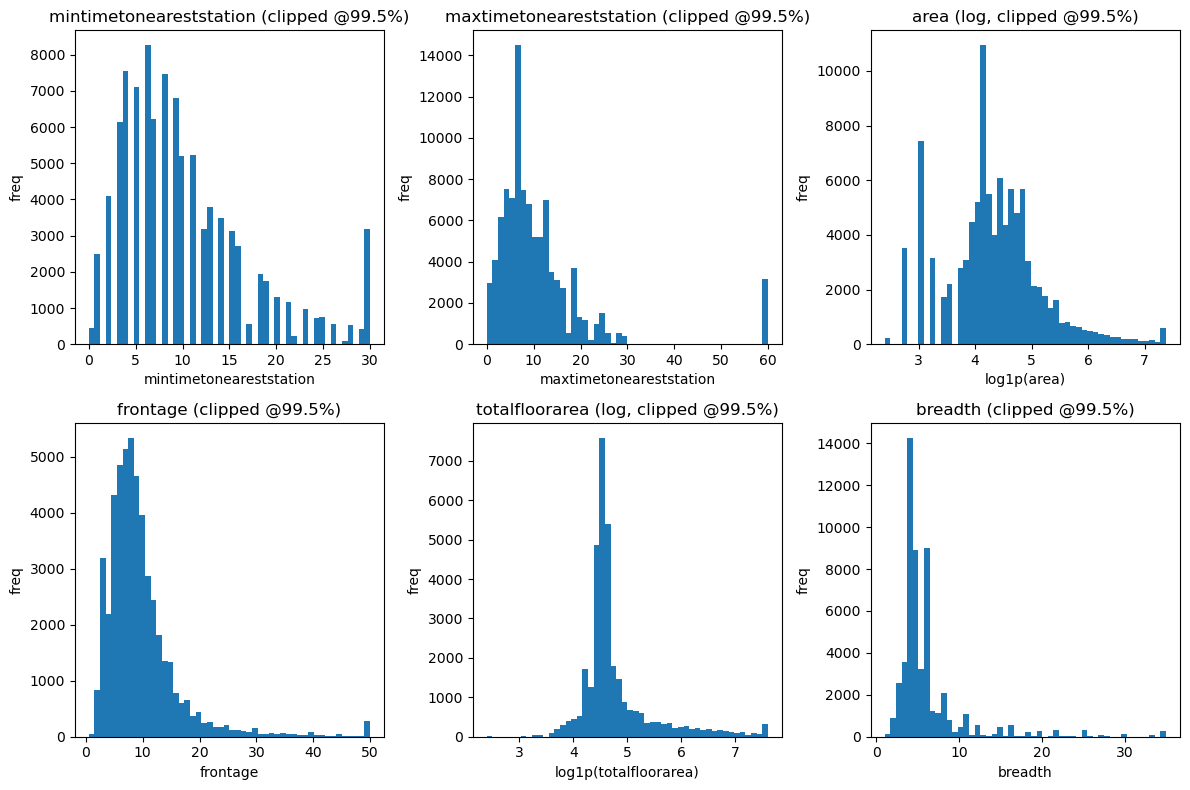

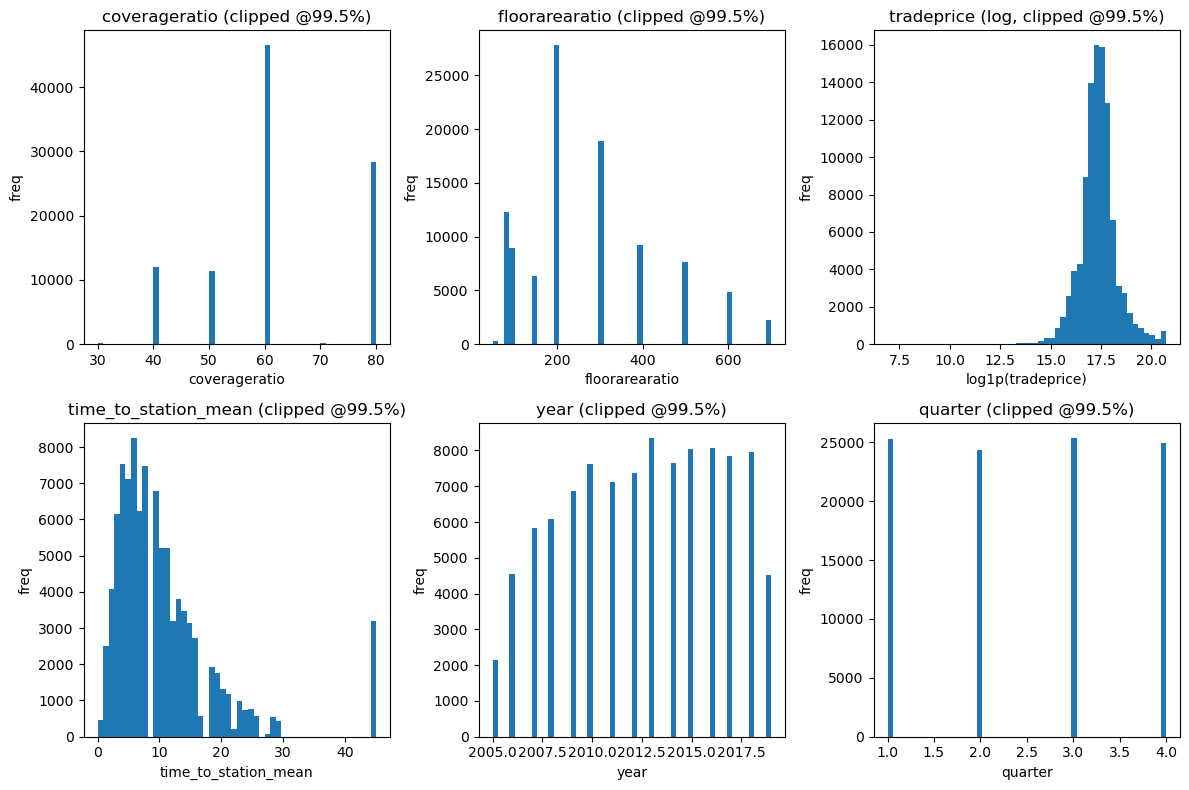

In [53]:
# Usando uma amostra só para gráficos
plot_df = df_tratado.sample(n=100_000, random_state=42) if len(df_tratado) > 120_000 else df_tratado

# Fazendo log nas colunas com cauda
log_cols = {"tradeprice", "totalfloorarea", "area"}

# plotando em lotes de 6 por figura
for i in range(0, len(num_cols), 6):
    cols = num_cols[i:i+6]
    n = len(cols)
    rows = (n + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(12, 4*rows))
    axes = axes.ravel() if n > 1 else [axes]

    for ax, col in zip(axes, cols):
        s = plot_df[col].dropna()

        # clip para reduzir a influência de outliers extremos
        hi = s.quantile(0.995)
        s = s.clip(upper=hi)

        if col in log_cols:
            ax.hist(np.log1p(s), bins=50)
            ax.set_ylabel("freq")
            ax.set_xlabel(f"log1p({col})")
            ax.set_title(f"{col} (log, clipped @99.5%)")
        else:
            ax.hist(s, bins=50)
            ax.set_ylabel("freq")
            ax.set_xlabel(col)
            ax.set_title(f"{col} (clipped @99.5%)")

    # limpa eixos vazios
    for ax in axes[n:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Medindo a correlação de variáveis numéricas

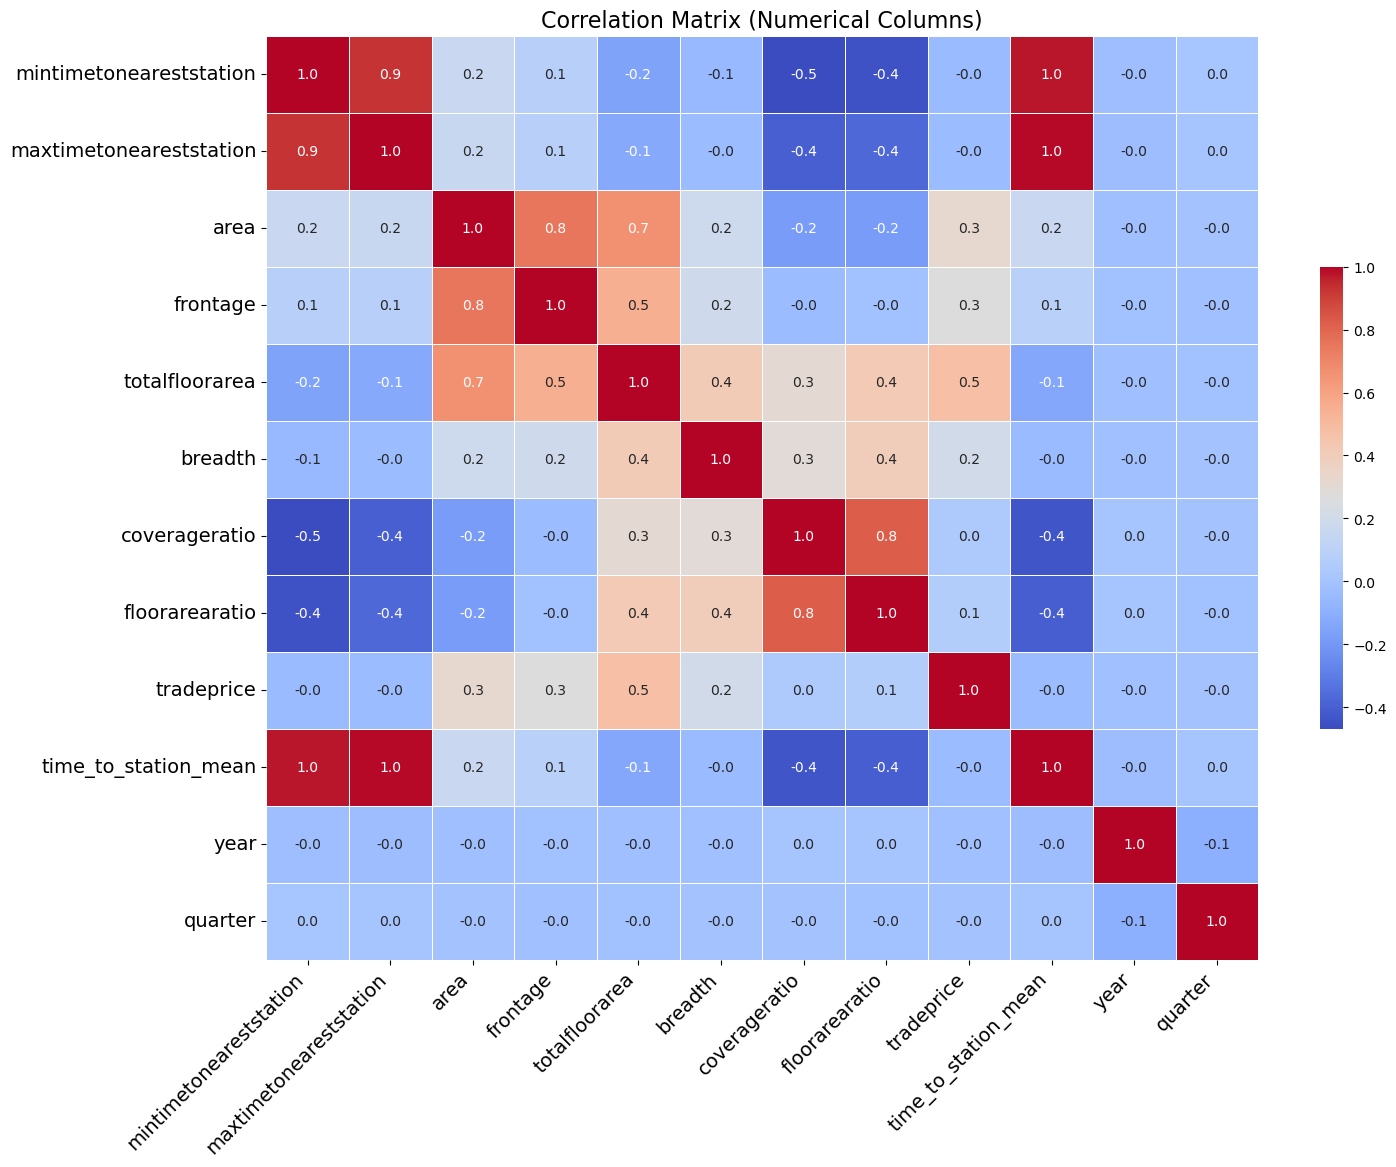

In [54]:
# Selecionando apenas colunas numéricas
df_numeric = df_tratado[num_cols]

# Calculando matriz de correlação
corr = df_numeric.corr()

# Plotando heatmap
f, ax = plt.subplots(figsize=(16, 12))

sns.heatmap(corr, annot=True, ax=ax, cmap='coolwarm', fmt=".1f", linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title('Correlation Matrix (Numerical Columns)', fontsize=16)
plt.show()

### Análise da correlação entre totalfloorarea e tradeprice

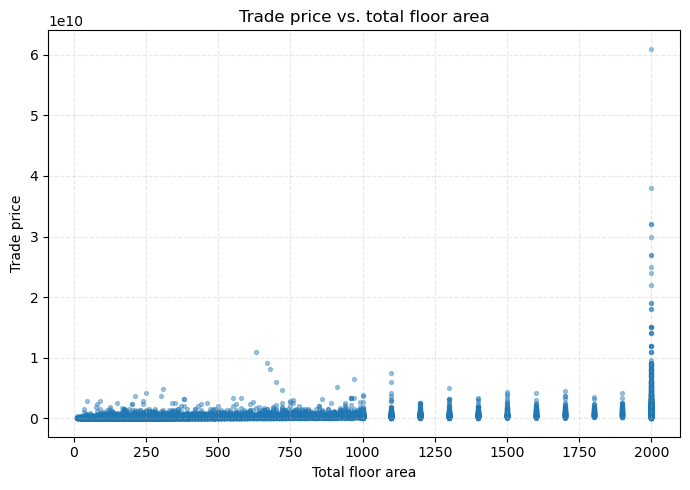

In [65]:
x = df_tratado["totalfloorarea"]
y = df_tratado["tradeprice"]

m = x.notna() & y.notna()     
x, y = x[m], y[m]

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=8, alpha=0.4)  
plt.xlabel("Total floor area")
plt.ylabel("Trade price")
plt.title("Trade price vs. total floor area")
plt.grid(True, ls="--", alpha=0.3)
plt.tight_layout()
plt.show()


Correlação não fica clara apenas fazendo um gráfico de dispersão

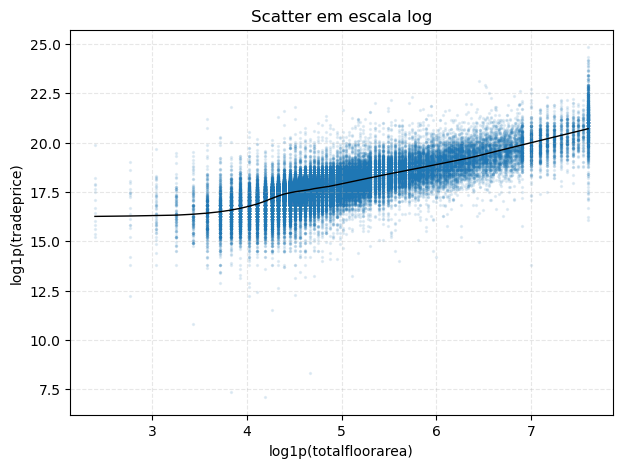

In [190]:
s = df_tratado[['totalfloorarea','tradeprice']].dropna()
x = np.log1p(s['totalfloorarea'])
y = np.log1p(s['tradeprice'])

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=2, alpha=0.1)

z = lowess(y, x, frac=0.2, it=0, return_sorted=True)
plt.plot(z[:,0], z[:,1], color='black', lw=1, label='LOWESS (frac=0.2)')

plt.xlabel('log1p(totalfloorarea)')
plt.ylabel('log1p(tradeprice)')
plt.title('Scatter em escala log')
plt.grid(True, ls='--', alpha=.3)
plt.show()


Fazendo a aplicação de logaritmo para normalizar, podemos perceber melhor a correlação existente.

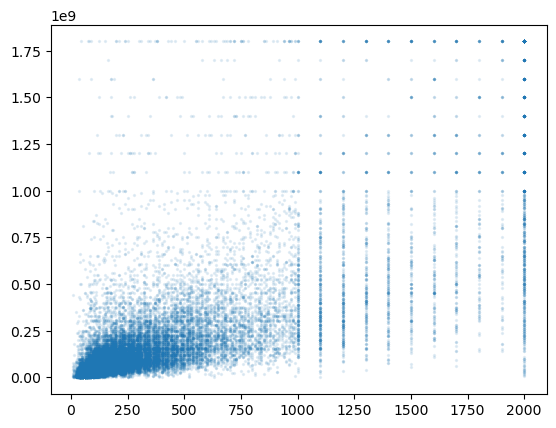

In [141]:
s_plot = s.copy()
s_plot['tradeprice'] = s_plot['tradeprice'].clip(upper=s_plot['tradeprice'].quantile(.995))
s_plot['totalfloorarea'] = s_plot['totalfloorarea'].clip(upper=s_plot['totalfloorarea'].quantile(.995))
plt.scatter(s_plot['totalfloorarea'], s_plot['tradeprice'], s=2, alpha=.1)


Retirada de outliers para deixar mais limpa a visualização

O teste abaixo é feito para testar a captação da correlação. Podemos ver que Spearmann capta melhor a correlação, por ela não ser linear. Já o pearson precisa do log para que consiga captar melhor a correlação

In [149]:
from scipy.stats import spearmanr
s = df_tratado[['totalfloorarea','tradeprice']].dropna()

pearson_raw  = s.corr().loc['totalfloorarea','tradeprice']
spearman_raw = s.corr(method='spearman').loc['totalfloorarea','tradeprice']

x = np.log1p(s['totalfloorarea'])
y = np.log1p(s['tradeprice'])
pearson_log  = np.corrcoef(x, y)[0,1]
spearman_log = spearmanr(x, y).correlation

print(pearson_raw, spearman_raw, pearson_log, spearman_log)


0.47723464306851415 0.5981819591278655 0.7702545574131452 0.5981819591278655


### Exibindo um heatmap com correlação de Spearman

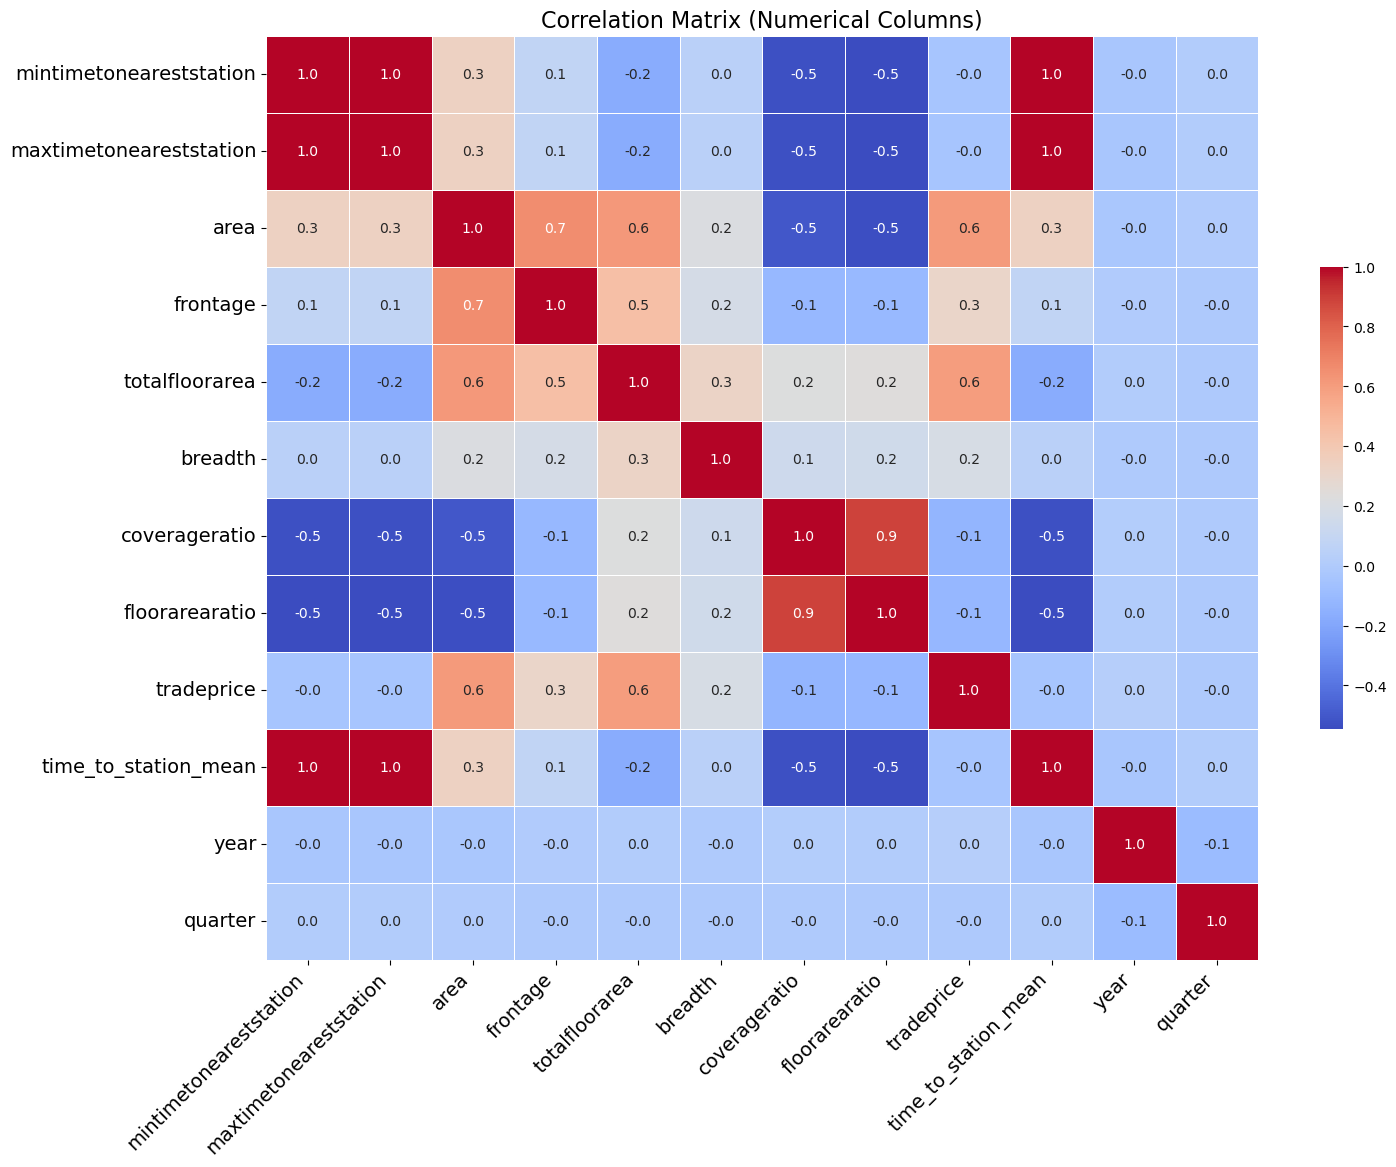

In [167]:
corr_s = df_numeric.corr(method='spearman')

# Plotando heatmap
f, ax = plt.subplots(figsize=(16, 12))

sns.heatmap(corr_s, annot=True, ax=ax, cmap='coolwarm', fmt=".1f", linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.title('Correlation Matrix (Numerical Columns)', fontsize=16)
plt.show()

### Analisando a correlação entre area e tradeprice

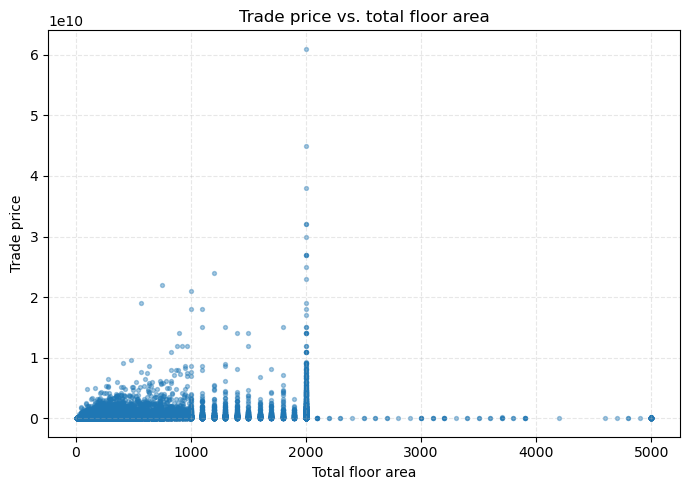

In [176]:
x = df_tratado["area"]
y = df_tratado["tradeprice"]

m = x.notna() & y.notna()    
x, y = x[m], y[m]

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=8, alpha=0.4)   
plt.xlabel("Total floor area")
plt.ylabel("Trade price")
plt.title("Trade price vs. total floor area")
plt.grid(True, ls="--", alpha=0.3)
plt.tight_layout()
plt.show()


Novamente uma correlação difícil de enxergar, abaixo farei uma visão com o log e uma visão sem outliers, para melhorar a visualização

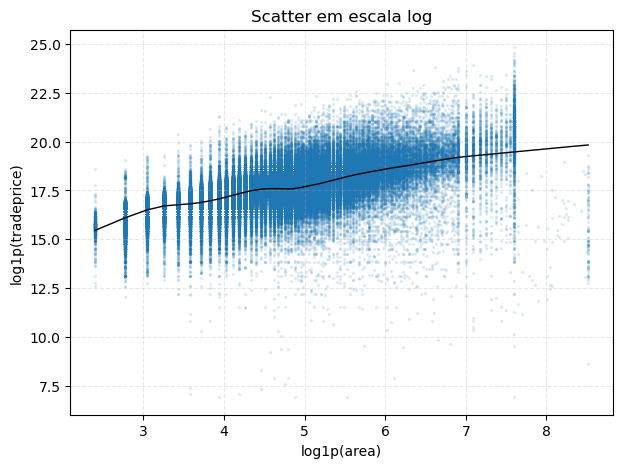

In [192]:
s = df_tratado[['area','tradeprice']].dropna()
x = np.log1p(s['area'])
y = np.log1p(s['tradeprice'])

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=2, alpha=0.1)

z = lowess(y, x, frac=0.2, it=0, return_sorted=True)
plt.plot(z[:,0], z[:,1], color='black', lw=1, label='LOWESS (frac=0.2)')

plt.xlabel('log1p(area)')
plt.ylabel('log1p(tradeprice)')
plt.title('Scatter em escala log')
plt.grid(True, ls='--', alpha=.3)
plt.show()


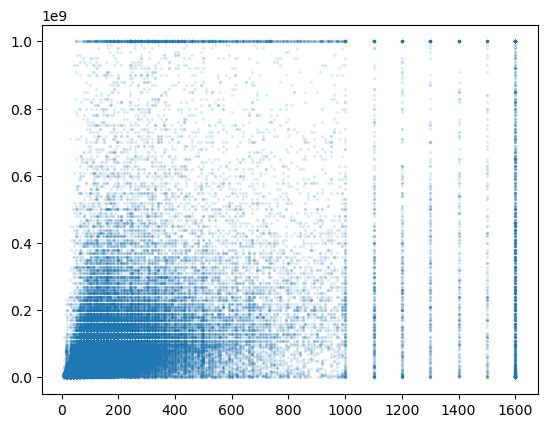

In [183]:
s_plot = s.copy()
s_plot['tradeprice'] = s_plot['tradeprice'].clip(upper=s_plot['tradeprice'].quantile(.995))
s_plot['area'] = s_plot['area'].clip(upper=s_plot['area'].quantile(.995))
plt.scatter(s_plot['area'], s_plot['tradeprice'], s=2, alpha=.1)


### Investigando se realmente não há uma relação entre tempo até a rodoviária e o preço do imóvel

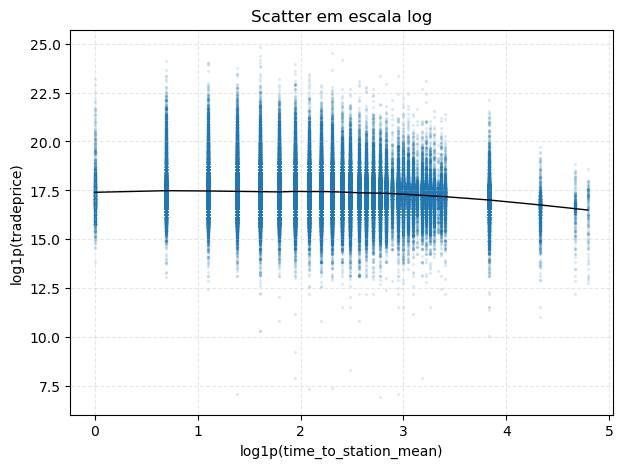

In [195]:
s = df_tratado[['time_to_station_mean','tradeprice']].dropna()
x = np.log1p(s['time_to_station_mean'])
y = np.log1p(s['tradeprice'])

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=2, alpha=0.1)

z = lowess(y, x, frac=0.2, it=0, return_sorted=True)
plt.plot(z[:,0], z[:,1], color='black', lw=1, label='LOWESS (frac=0.2)')

plt.xlabel('log1p(time_to_station_mean)')
plt.ylabel('log1p(tradeprice)')
plt.title('Scatter em escala log')
plt.grid(True, ls='--', alpha=.3)
plt.show()


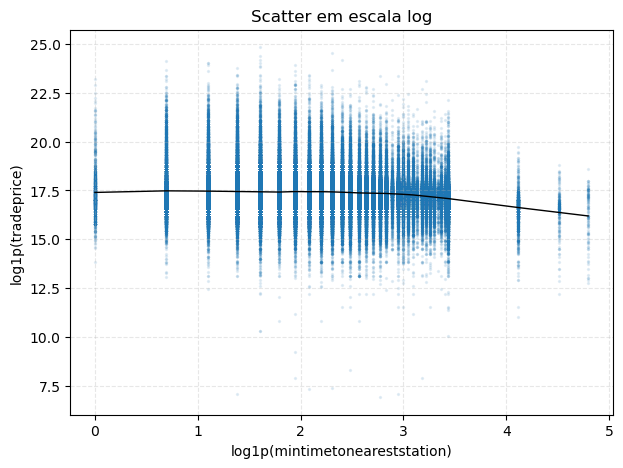

In [197]:
s = df_tratado[['mintimetoneareststation','tradeprice']].dropna()
x = np.log1p(s['mintimetoneareststation'])
y = np.log1p(s['tradeprice'])

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=2, alpha=0.1)

z = lowess(y, x, frac=0.2, it=0, return_sorted=True)
plt.plot(z[:,0], z[:,1], color='black', lw=1, label='LOWESS (frac=0.2)')

plt.xlabel('log1p(mintimetoneareststation)')
plt.ylabel('log1p(tradeprice)')
plt.title('Scatter em escala log')
plt.grid(True, ls='--', alpha=.3)
plt.show()


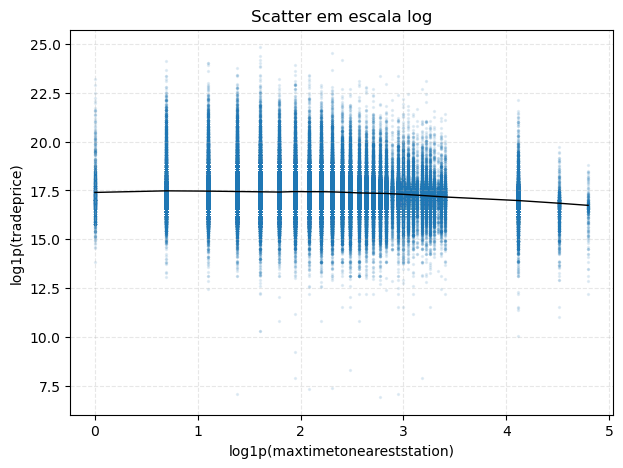

In [199]:
s = df_tratado[['maxtimetoneareststation','tradeprice']].dropna()
x = np.log1p(s['maxtimetoneareststation'])
y = np.log1p(s['tradeprice'])

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=2, alpha=0.1)

z = lowess(y, x, frac=0.2, it=0, return_sorted=True)
plt.plot(z[:,0], z[:,1], color='black', lw=1, label='LOWESS (frac=0.2)')

plt.xlabel('log1p(maxtimetoneareststation)')
plt.ylabel('log1p(tradeprice)')
plt.title('Scatter em escala log')
plt.grid(True, ls='--', alpha=.3)
plt.show()


### Entendendo se o tipo de imóvel tem correlação sobre o preço

C:\Users\cicer\AppData\Local\Temp\ipykernel_77868\131492893.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)  # showfliers=True para mostrar outliers


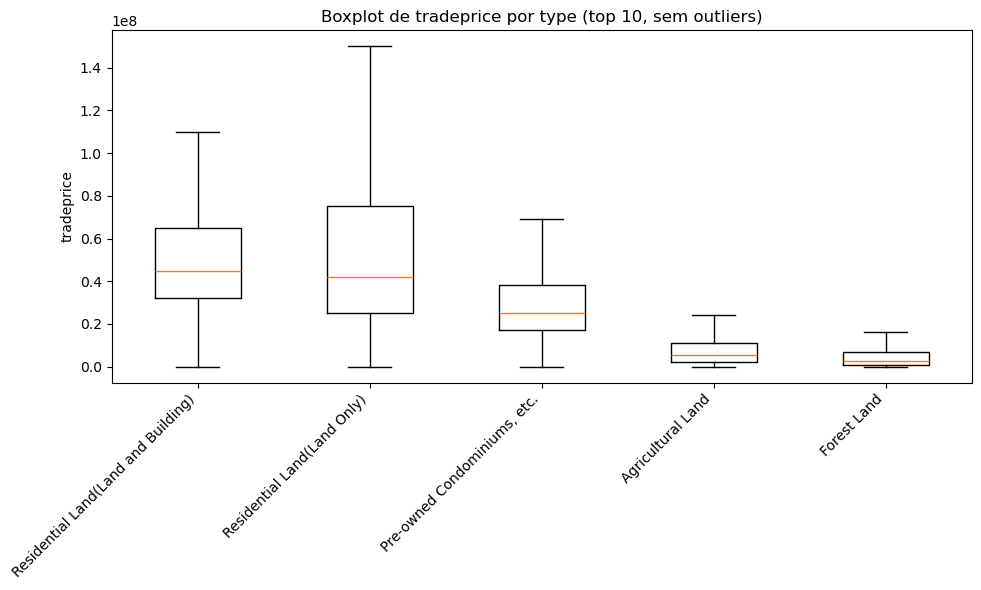

In [72]:
cat_col = "type"
num_col = "tradeprice"

# linhas completas
d = df_tratado[[cat_col, num_col]].dropna()

# As 10 categorias mais frequentes
top = d[cat_col].value_counts().head(10).index
d = d[d[cat_col].isin(top)]

# Colocando em ordem por mediana
order = (
    d.groupby(cat_col)[num_col]
      .median()
      .sort_values(ascending=False)
      .index.tolist()
)

data = [d.loc[d[cat_col] == c, num_col].values for c in order]

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=order, showfliers=False)  # showfliers=True para mostrar outliers
plt.xticks(rotation=45, ha="right")
plt.ylabel(num_col)
plt.title(f"Boxplot de {num_col} por {cat_col} (top 10, sem outliers)")
plt.tight_layout()
plt.show()


Executando teste de Kruskal Wallis:

O teste de Kruskal-Wallis (teste H) é um teste estatístico não paramétrico usado para comparar três ou mais grupos independentes e determinar se há diferenças estatisticamente significativas entre eles.
Como o preço dos imóveis (tradeprice) não segue uma distribuição normal, é necessário fazer um teste não paramétrico.
O teste de Kruskal-Wallis é utilizado quando os pressupostos para uma análise de variância unidirecional não são atendidos. Como o teste de Kruskal-Wallis é um teste não paramétrico, os dados utilizados não precisam ser distribuídos normalmente.

https://numiqo.com/tutorial/kruskal-wallis-test

In [82]:
groups = [g['tradeprice'].dropna().values
          for _, g in df_tratado.groupby('type') if len(g)>1]

H, p = kruskal(*groups)
k = len(groups); n = sum(len(g) for g in groups)
epsilon2 = (H - k + 1) / (n - k)   

print(f"Kruskal: H={H:.2f}, p={p:.3g}, ε²={epsilon2:.4f}")


Kruskal: H=54661.14, p=0, ε²=0.1680


Análise do resultado: Rejeitamos H0, porque o valore de é menor que 0.05. Analisando o tamanho do efeito, vemos que ele é moderado-grande e que aproximadamente 17% da variabilidade entre os ranks de preço é atribuída ao fator tipo do imóvel

In [104]:
cat = "type"
val = "tradeprice"

# dados sem nulos
d = df[[cat, val]].dropna().copy()

# Selecionando top 12
top_k = 12
top_levels = d[cat].value_counts().head(top_k).index
d2 = d[d[cat].isin(top_levels)].copy()

# Dunn com correção para múltiplas comparações
p_mat = sp.posthoc_dunn(d2, val_col=val, group_col=cat, p_adjust='holm')

# Transforma a matriz em formato longo para filtrar
p_long = (p_mat.reset_index()
          .melt(id_vars='index', var_name='grupo2', value_name='p_adj')
          .rename(columns={'index':'grupo1'}))

# manter apenas pares únicos (grupo1 < grupo2)
p_long = p_long[p_long['grupo1'] < p_long['grupo2']].copy()

# Adiciona n por grupo e diferença de medianas
med = d2.groupby(cat)[val].median().rename('mediana')
n   = d2.groupby(cat)[val].size().rename('n')
stats = pd.concat([med, n], axis=1)

p_long = (p_long
          .merge(stats, left_on='grupo1', right_index=True)
          .merge(stats, left_on='grupo2', right_index=True, suffixes=('_1','_2')))
p_long['diff_mediana'] = p_long['mediana_1'] - p_long['mediana_2']

# Efeito não-paramétrico por par — Cliff’s delta
def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    # versão eficiente via ordenação
    a_sorted = np.sort(a); b_sorted = np.sort(b)
    import bisect
    greater = sum(len(b_sorted) - np.searchsorted(b_sorted, ai, side='right') for ai in a_sorted)
    less    = sum(np.searchsorted(b_sorted, ai, side='left') for ai in a_sorted)
    delta = (greater - less) / (len(a_sorted)*len(b_sorted))
    return delta

# calcula delta para os pares de interesse
pair_to_delta = {}
for g1, g2 in p_long[['grupo1','grupo2']].itertuples(index=False):
    a = d2.loc[d2[cat]==g1, val].values
    b = d2.loc[d2[cat]==g2, val].values
    pair_to_delta[(g1,g2)] = cliffs_delta(a, b)

p_long['cliffs_delta'] = p_long.apply(lambda r: pair_to_delta[(r['grupo1'], r['grupo2'])], axis=1)

# ordenar pelos p-values
result = p_long.sort_values(['p_adj', 'grupo1', 'grupo2'])

# Mostra top 20 pares mais significativos e o tamanho do efeito
result[['grupo1','grupo2','n_1','n_2','p_adj','diff_mediana','cliffs_delta']].head(20)

,grupo1,grupo2,n_1,n_2,p_adj,diff_mediana,cliffs_delta
17,"Pre-owned Condominiums, etc.",Residential Land(Land Only),147639,63585,0.000000e+00,-17000000.0,0.395872
22,"Pre-owned Condominiums, etc.",Residential Land(Land and Building),147639,113621,0.000000e+00,-20000000.0,0.509360
21,Forest Land,Residential Land(Land and Building),339,113621,9.928156e-246,-42200000.0,0.864821
16,Forest Land,Residential Land(Land Only),339,63585,2.123558e-207,-39200000.0,0.832154
23,Residential Land(Land Only),Residential Land(Land and Building),63585,113621,9.143317e-194,-3000000.0,0.061511
11,Forest Land,"Pre-owned Condominiums, etc.",339,147639,3.902154e-69,-22200000.0,0.757945
20,Agricultural Land,Residential Land(Land and Building),76,113621,7.019812e-54,-39650000.0,0.863508
15,Agricultural Land,Residential Land(Land Only),76,63585,1.238782e-45,-36650000.0,0.816322
10,Agricultural Land,"Pre-owned Condominiums, etc.",76,147639,2.185387e-15,-19650000.0,0.714508
5,Agricultural Land,Forest Land,76,339,7.478584e-01,2550000.0,-0.221666


teste post hoc de Dunn: Realiza comparações pareadas entre cada grupo independente e informa quais grupos são estatisticamente significativamente diferentes em algum nível de α.
Em outras palavras, o teste acima mostra os grupos com maiores diferenças entre eles. https://www.statology.org/dunns-test/

Significado de cada coluna:
gupos 1 e 2: Grupos que estão sendo comparados.
n_1 e n_2: tamanho de amostras de cada grupo.
p_adj: p-valor ajustado para múltiplas comparações. Nesse caso calculei utilizando o ajuste de Holm por ser robusto. se p_adj < 0.05, diferença estatisticamente significativa.
diff_mediana: diferença da mediana do grupo1 - mediana do grupo2.
cliffs_delta: Tamanho do efeito não paramétrico(-1 a 1). valores positivos indicam que o grupo1 tende a ter valores menores que o grupo2, valores negativos indicam o contrário.

Insight da análise: Residential Land (Land and Building) e Land Only têm preços muito acima de Forest e Agricultural; condos ficam no meio, mas abaixo dos dois tipos “Residential Land”.

C:\Users\cicer\AppData\Local\Temp\ipykernel_77868\3093284615.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)  # showfliers=True para mostrar outliers


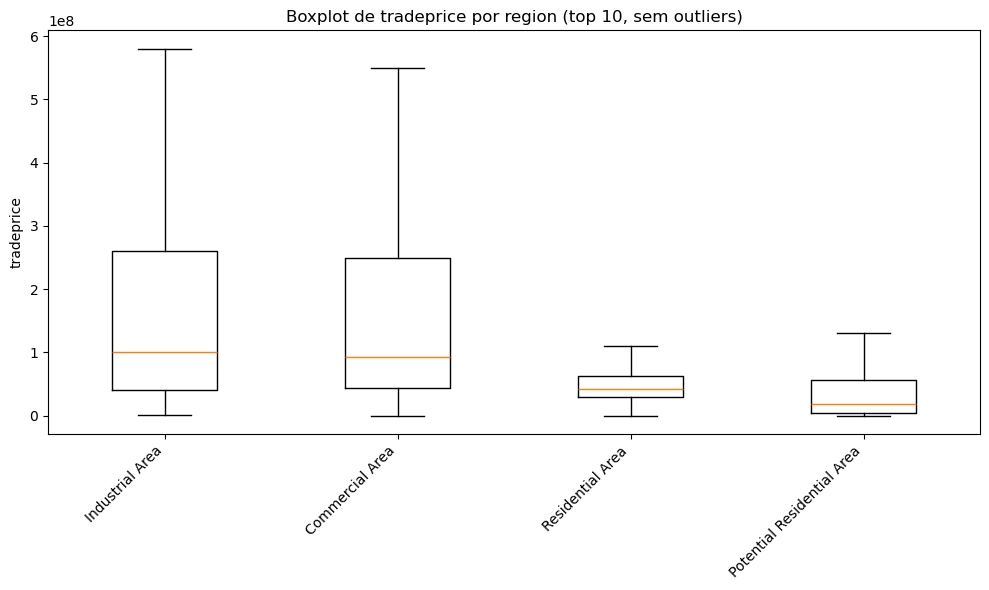

In [74]:
cat_col = "region"
num_col = "tradeprice"

d = df[[cat_col, num_col]].dropna()

# As 10 categorias mais frequentes
top = d[cat_col].value_counts().head(10).index
d = d[d[cat_col].isin(top)]

# Colocando em ordem por mediana
order = (
    d.groupby(cat_col)[num_col]
      .median()
      .sort_values(ascending=False)
      .index.tolist()
)

data = [d.loc[d[cat_col] == c, num_col].values for c in order]

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=order, showfliers=False)  # showfliers=True para mostrar outliers
plt.xticks(rotation=45, ha="right")
plt.ylabel(num_col)
plt.title(f"Boxplot de {num_col} por {cat_col} (top 10, sem outliers)")
plt.tight_layout()
plt.show()


### Entendendo se a região tem correlação com o preço

Executando teste de Kruskal Wallis

In [111]:
groups = [g['tradeprice'].dropna().values
          for _, g in df_tratado.groupby('region') if len(g)>1]

H, p = kruskal(*groups)
k = len(groups); n = sum(len(g) for g in groups)
epsilon2 = (H - k + 1) / (n - k)   

print(f"Kruskal: H={H:.2f}, p={p:.3g}, ε²={epsilon2:.4f}")


Kruskal: H=10657.07, p=0, ε²=0.0601


Análise do resultado: p aproximadamente igual a 0. O que significa que os preços variam por região. E, de acordo com o epsilon, aproximadamente 6% da variabilidade do preço é explicada pela região.

In [122]:
cat = "region"
val = "tradeprice"

d = df_tratado[[cat, val]].dropna().copy()

top_k = 12
top_levels = d[cat].value_counts().head(top_k).index
d2 = d[d[cat].isin(top_levels)].copy()

p_mat = sp.posthoc_dunn(d2, val_col=val, group_col=cat, p_adjust='holm')

p_long = (p_mat.reset_index()
          .melt(id_vars='index', var_name='grupo2', value_name='p_adj')
          .rename(columns={'index':'grupo1'}))

p_long = p_long[p_long['grupo1'] < p_long['grupo2']].copy()

med = d2.groupby(cat)[val].median().rename('mediana')
n   = d2.groupby(cat)[val].size().rename('n')
stats = pd.concat([med, n], axis=1)

p_long = (p_long
          .merge(stats, left_on='grupo1', right_index=True)
          .merge(stats, left_on='grupo2', right_index=True, suffixes=('_1','_2')))
p_long['diff_mediana'] = p_long['mediana_1'] - p_long['mediana_2']

def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    # versão eficiente via ordenação
    a_sorted = np.sort(a); b_sorted = np.sort(b)
    import bisect
    greater = sum(len(b_sorted) - np.searchsorted(b_sorted, ai, side='right') for ai in a_sorted)
    less    = sum(np.searchsorted(b_sorted, ai, side='left') for ai in a_sorted)
    delta = (greater - less) / (len(a_sorted)*len(b_sorted))
    return delta

pair_to_delta = {}
for g1, g2 in p_long[['grupo1','grupo2']].itertuples(index=False):
    a = d2.loc[d2[cat]==g1, val].values
    b = d2.loc[d2[cat]==g2, val].values
    pair_to_delta[(g1,g2)] = cliffs_delta(a, b)

p_long['cliffs_delta'] = p_long.apply(lambda r: pair_to_delta[(r['grupo1'], r['grupo2'])], axis=1)

result = p_long.sort_values(['p_adj', 'grupo1', 'grupo2'])

result[['grupo1','grupo2','n_1','n_2','p_adj','diff_mediana','cliffs_delta']].head(20)

,grupo1,grupo2,n_1,n_2,p_adj,diff_mediana,cliffs_delta
12,Commercial Area,Residential Area,18507,157201,0.000000e+00,50000000.0,-0.448755
8,Commercial Area,Potential Residential Area,18507,403,3.058452e-159,74000000.0,-0.607769
13,Industrial Area,Residential Area,1095,157201,3.520419e-138,57000000.0,-0.436596
9,Industrial Area,Potential Residential Area,1095,403,9.271899e-117,81000000.0,-0.598992
14,Potential Residential Area,Residential Area,403,157201,5.090258e-31,-24000000.0,0.357091
4,Commercial Area,Industrial Area,18507,1095,6.117912e-01,-7000000.0,0.015311


Avaliação dos resultados: As maiores diferenças práticas aparecem quando comparamos Commercial/Industrial com Potential Residential e Residential.
O cenário atual é: Industrial ≈ Commercial > Residential > Potential Residential

C:\Users\cicer\AppData\Local\Temp\ipykernel_77868\2837133821.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)  # showfliers=True para mostrar outliers


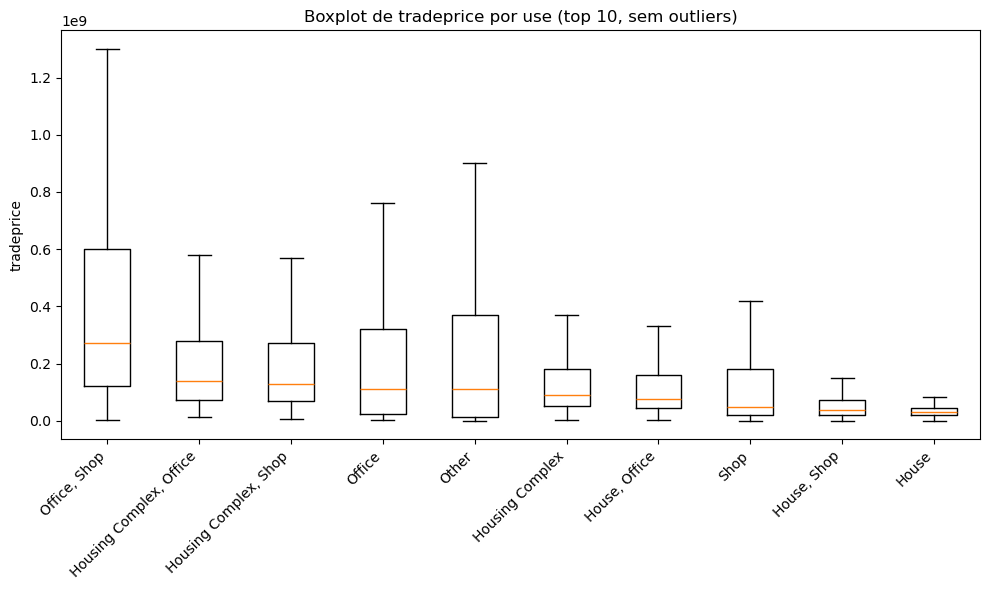

In [76]:
cat_col = "use"
num_col = "tradeprice"

d = df[[cat_col, num_col]].dropna()

top = d[cat_col].value_counts().head(10).index
d = d[d[cat_col].isin(top)]

order = (
    d.groupby(cat_col)[num_col]
      .median()
      .sort_values(ascending=False)
      .index.tolist()
)

data = [d.loc[d[cat_col] == c, num_col].values for c in order]

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=order, showfliers=False)  # showfliers=True para mostrar outliers
plt.xticks(rotation=45, ha="right")
plt.ylabel(num_col)
plt.title(f"Boxplot de {num_col} por {cat_col} (top 10, sem outliers)")
plt.tight_layout()
plt.show()


### Analisando se há correlação entre cidade e preço (municipality e tradeprice)

C:\Users\cicer\AppData\Local\Temp\ipykernel_77868\3301320874.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


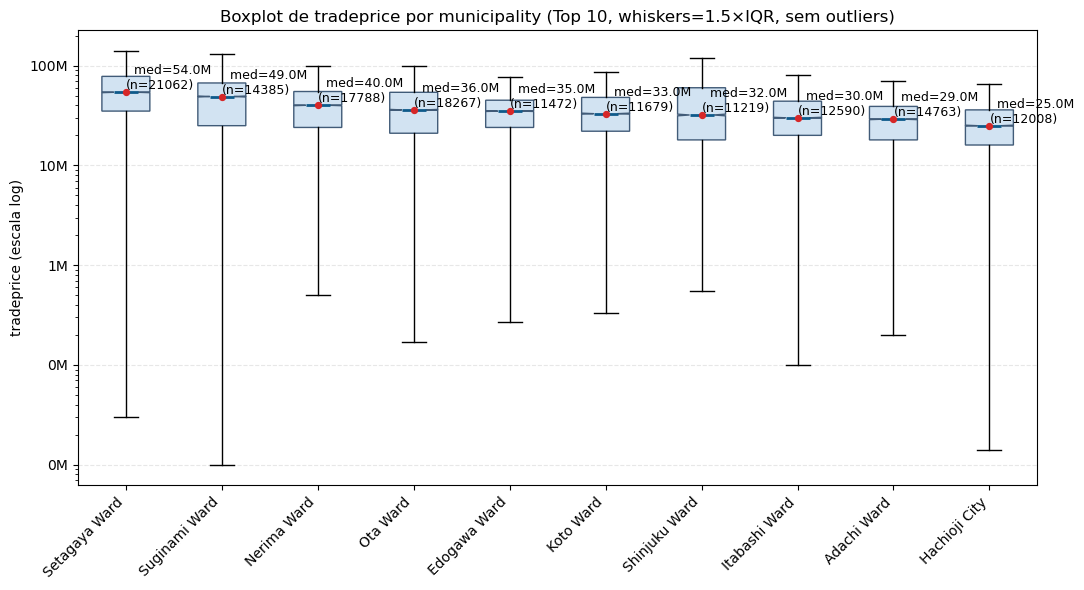

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

cat_col = "municipality"
num_col = "tradeprice"

d = df[[cat_col, num_col]].dropna()
d = d[d[num_col] > 0]

top = d[cat_col].value_counts().head(10).index
d = d[d[cat_col].isin(top)]

order = (
    d.groupby(cat_col)[num_col]
     .median()
     .sort_values(ascending=False)
     .index.tolist()
)

data = [d.loc[d[cat_col] == c, num_col].values for c in order]
med  = [np.median(v) for v in data]
n    = [len(v) for v in data]

fig, ax = plt.subplots(figsize=(11, 6))

bp = ax.boxplot(
    data,
    labels=order,
    showfliers=False,     
    notch=True,
    patch_artist=True     
)

for box in bp['boxes']:
    box.set(facecolor="#cde0f1", edgecolor="#2f4b6a", alpha=0.9)
for medline in bp['medians']:
    medline.set(color="#0e5a8a", linewidth=2)

ax.set_yscale("log")

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e6:.0f}M"))

ax.scatter(np.arange(1, len(med)+1), med, c="#d62728", s=18, zorder=3, label="mediana")
for i, (m, ni) in enumerate(zip(med, n), start=1):
    ax.text(i, m, f"  med={m/1e6:.1f}M\n(n={ni})", va="bottom", ha="left", fontsize=9)

ax.grid(True, axis="y", ls="--", alpha=.3)
ax.set_ylabel(f"{num_col} (escala log)")
ax.set_xlabel("")
ax.set_title(f"Boxplot de {num_col} por {cat_col} (Top 10, whiskers=1.5×IQR, sem outliers)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [216]:
groups = [g['tradeprice'].dropna().values
          for _, g in df_tratado.groupby('municipality') if len(g)>1]

H, p = kruskal(*groups)
k = len(groups); n = sum(len(g) for g in groups)
epsilon2 = (H - k + 1) / (n - k)  

print(f"Kruskal: H={H:.2f}, p={p:.3g}, ε²={epsilon2:.4f}")

Kruskal: H=30997.22, p=0, ε²=0.0951


O teste aponta que há diferenças de preço entre os municípios

In [218]:
cat = "municipality"
val = "tradeprice"

d = df_tratado[[cat, val]].dropna().copy()

top_k = 12
top_levels = d[cat].value_counts().head(top_k).index
d2 = d[d[cat].isin(top_levels)].copy()

p_mat = sp.posthoc_dunn(d2, val_col=val, group_col=cat, p_adjust='holm')

p_long = (p_mat.reset_index()
          .melt(id_vars='index', var_name='grupo2', value_name='p_adj')
          .rename(columns={'index':'grupo1'}))

p_long = p_long[p_long['grupo1'] < p_long['grupo2']].copy()

med = d2.groupby(cat)[val].median().rename('mediana')
n   = d2.groupby(cat)[val].size().rename('n')
stats = pd.concat([med, n], axis=1)

p_long = (p_long
          .merge(stats, left_on='grupo1', right_index=True)
          .merge(stats, left_on='grupo2', right_index=True, suffixes=('_1','_2')))
p_long['diff_mediana'] = p_long['mediana_1'] - p_long['mediana_2']

def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    a_sorted = np.sort(a); b_sorted = np.sort(b)
    import bisect
    greater = sum(len(b_sorted) - np.searchsorted(b_sorted, ai, side='right') for ai in a_sorted)
    less    = sum(np.searchsorted(b_sorted, ai, side='left') for ai in a_sorted)
    delta = (greater - less) / (len(a_sorted)*len(b_sorted))
    return delta

pair_to_delta = {}
for g1, g2 in p_long[['grupo1','grupo2']].itertuples(index=False):
    a = d2.loc[d2[cat]==g1, val].values
    b = d2.loc[d2[cat]==g2, val].values
    pair_to_delta[(g1,g2)] = cliffs_delta(a, b)

p_long['cliffs_delta'] = p_long.apply(lambda r: pair_to_delta[(r['grupo1'], r['grupo2'])], axis=1)

result = p_long.sort_values(['p_adj', 'grupo1', 'grupo2'])

result[['grupo1','grupo2','n_1','n_2','p_adj','diff_mediana','cliffs_delta']].head(20)

,grupo1,grupo2,n_1,n_2,p_adj,diff_mediana,cliffs_delta
72,Adachi Ward,Nerima Ward,14763,17788,0.000000e+00,-11000000.0,0.272154
96,Adachi Ward,Setagaya Ward,14763,21062,0.000000e+00,-25000000.0,0.491101
132,Adachi Ward,Suginami Ward,14763,14385,0.000000e+00,-20000000.0,0.356685
97,Edogawa Ward,Setagaya Ward,11472,21062,0.000000e+00,-19000000.0,0.390902
74,Hachioji City,Nerima Ward,12008,17788,0.000000e+00,-15000000.0,0.360037
86,Hachioji City,Ota Ward,12008,18267,0.000000e+00,-11000000.0,0.282346
98,Hachioji City,Setagaya Ward,12008,21062,0.000000e+00,-29000000.0,0.562056
110,Hachioji City,Shinagawa Ward,12008,10914,0.000000e+00,-12000000.0,0.305972
134,Hachioji City,Suginami Ward,12008,14385,0.000000e+00,-24000000.0,0.431422
99,Itabashi Ward,Setagaya Ward,12590,21062,0.000000e+00,-24000000.0,0.437280


### Analisando se há diferenças de preço entre os distritos

C:\Users\cicer\AppData\Local\Temp\ipykernel_77868\1526397869.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


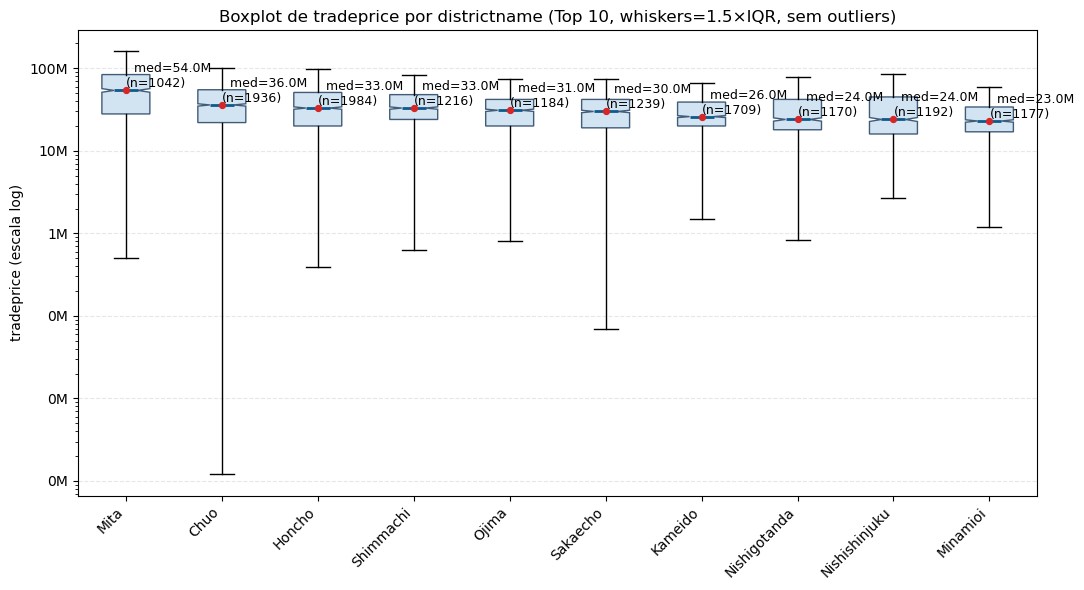

In [228]:
cat_col = "districtname"
num_col = "tradeprice"

d = df[[cat_col, num_col]].dropna()
d = d[d[num_col] > 0]

top = d[cat_col].value_counts().head(10).index
d = d[d[cat_col].isin(top)]

order = (
    d.groupby(cat_col)[num_col]
     .median()
     .sort_values(ascending=False)
     .index.tolist()
)

data = [d.loc[d[cat_col] == c, num_col].values for c in order]
med  = [np.median(v) for v in data]
n    = [len(v) for v in data]

fig, ax = plt.subplots(figsize=(11, 6))

bp = ax.boxplot(
    data,
    labels=order,
    showfliers=False,      
    notch=True,
    patch_artist=True      
)

for box in bp['boxes']:
    box.set(facecolor="#cde0f1", edgecolor="#2f4b6a", alpha=0.9)
for medline in bp['medians']:
    medline.set(color="#0e5a8a", linewidth=2)

ax.set_yscale("log")

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e6:.0f}M"))

ax.scatter(np.arange(1, len(med)+1), med, c="#d62728", s=18, zorder=3, label="mediana")
for i, (m, ni) in enumerate(zip(med, n), start=1):
    ax.text(i, m, f"  med={m/1e6:.1f}M\n(n={ni})", va="bottom", ha="left", fontsize=9)

ax.grid(True, axis="y", ls="--", alpha=.3)
ax.set_ylabel(f"{num_col} (escala log)")
ax.set_xlabel("")
ax.set_title(f"Boxplot de {num_col} por {cat_col} (Top 10, whiskers=1.5×IQR, sem outliers)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Podemos observar neste resultado que temos grupos realmente distintos uns dos outros. Se destacando por Setagaya, Shinagawa, Shinjuku e Nerima com as maiores diferenças para as outras cidades, baseado na mediana.

In [222]:
groups = [g['tradeprice'].dropna().values
          for _, g in df_tratado.groupby('districtname') if len(g)>1]

H, p = kruskal(*groups)
k = len(groups); n = sum(len(g) for g in groups)
epsilon2 = (H - k + 1) / (n - k)   # efeito ~ proporção explicada

print(f"Kruskal: H={H:.2f}, p={p:.3g}, ε²={epsilon2:.4f}")

Kruskal: H=52934.32, p=0, ε²=0.1592


In [224]:
cat = "districtname"
val = "tradeprice"

d = df_tratado[[cat, val]].dropna().copy()

top_k = 12
top_levels = d[cat].value_counts().head(top_k).index
d2 = d[d[cat].isin(top_levels)].copy()

p_mat = sp.posthoc_dunn(d2, val_col=val, group_col=cat, p_adjust='holm')

p_long = (p_mat.reset_index()
          .melt(id_vars='index', var_name='grupo2', value_name='p_adj')
          .rename(columns={'index':'grupo1'}))

p_long = p_long[p_long['grupo1'] < p_long['grupo2']].copy()

med = d2.groupby(cat)[val].median().rename('mediana')
n   = d2.groupby(cat)[val].size().rename('n')
stats = pd.concat([med, n], axis=1)

p_long = (p_long
          .merge(stats, left_on='grupo1', right_index=True)
          .merge(stats, left_on='grupo2', right_index=True, suffixes=('_1','_2')))
p_long['diff_mediana'] = p_long['mediana_1'] - p_long['mediana_2']

def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    a_sorted = np.sort(a); b_sorted = np.sort(b)
    import bisect
    greater = sum(len(b_sorted) - np.searchsorted(b_sorted, ai, side='right') for ai in a_sorted)
    less    = sum(np.searchsorted(b_sorted, ai, side='left') for ai in a_sorted)
    delta = (greater - less) / (len(a_sorted)*len(b_sorted))
    return delta

pair_to_delta = {}
for g1, g2 in p_long[['grupo1','grupo2']].itertuples(index=False):
    a = d2.loc[d2[cat]==g1, val].values
    b = d2.loc[d2[cat]==g2, val].values
    pair_to_delta[(g1,g2)] = cliffs_delta(a, b)

p_long['cliffs_delta'] = p_long.apply(lambda r: pair_to_delta[(r['grupo1'], r['grupo2'])], axis=1)

result = p_long.sort_values(['p_adj', 'grupo1', 'grupo2'])

result[['grupo1','grupo2','n_1','n_2','p_adj','diff_mediana','cliffs_delta']].head(20)

,grupo1,grupo2,n_1,n_2,p_adj,diff_mediana,cliffs_delta
64,Minamioi,Mita,1177,1042,4.422996e-115,-31000000.0,0.499538
62,Kameido,Mita,1709,1042,8.017246e-88,-28000000.0,0.437947
77,Mita,Nishigotanda,1042,1170,1.755161e-83,30000000.0,-0.452261
89,Mita,Nishishinjuku,1042,1192,3.878417e-79,30000000.0,-0.404151
137,Mita,Takinogawa,1042,1034,6.509611e-65,28000000.0,-0.427934
113,Mita,Sakaecho,1042,1239,8.708304e-57,24000000.0,-0.412061
101,Mita,Ojima,1042,1184,1.315421e-51,23000000.0,-0.402952
48,Chuo,Minamioi,1936,1177,5.031358e-48,13000000.0,-0.305530
61,Honcho,Mita,1984,1042,1.999711e-44,-21000000.0,0.322675
51,Midoricho,Minamioi,1030,1177,4.113236e-35,12000000.0,-0.327065


### Análise com ID único de localização

criando um ID único juntando o distrito e o município. Isso ajuda a identificarmos as localidades de maneira mais assertiva e não repetir ou confundir localidades.

In [280]:
# Criando ID único normalizando os nomes
def norm(s):
    if pd.isna(s): return 'UNK'
    s = str(s).strip()
    s = ud.normalize('NFKC', s)     
    s = ' '.join(s.split())         
    return s

df_tratado['district_norm'] = df_tratado['districtname'].map(norm)

df_tratado['district_uid'] = df_tratado['municipalitycode'].astype(str) + '|' + df_tratado['district_norm']



In [327]:
#Sumário de medias separadas por id único das cidades ordenadas pela mediana do preço de venda
summary = (df_tratado.groupby("district_uid")['tradeprice']
             .agg(n="size",
                  median="median",
                  p25=lambda s: s.quantile(.25),
                  p75=lambda s: s.quantile(.75),
                  mean="mean",
                  total="sum")
          )
summary["iqr"] = summary["p75"] - summary["p25"]


summary_med = summary.sort_values("median", ascending=False)
#summary_tot = summary.sort_values("total",  ascending=False)

summary_med.head(10)


,n,median,p25,p75,mean,total,iqr
district_uid,,,,,,,
13108|Aomi,2,8.775000e+09,4.662500e+09,1.288750e+10,8.775000e+09,1.755000e+10,8.225000e+09
13101|Kioicho,5,3.900000e+09,3.100000e+09,7.000000e+09,4.558000e+09,2.279000e+10,3.900000e+09
13111|Heiwajima,3,3.300000e+09,2.300000e+09,5.250000e+09,3.933333e+09,1.180000e+10,2.950000e+09
13108|Wakasu,2,1.650000e+09,1.475000e+09,1.825000e+09,1.650000e+09,3.300000e+09,3.500000e+08
13101|Kandamatsunagacho,1,1.600000e+09,1.600000e+09,1.600000e+09,1.600000e+09,1.600000e+09,0.000000e+00
13101|Kasumigaseki,2,7.500000e+08,5.250000e+08,9.750000e+08,7.500000e+08,1.500000e+09,4.500000e+08
13101|Yuurakucho,4,7.250000e+08,3.375000e+08,1.475000e+09,1.087500e+09,4.350000e+09,1.137500e+09
13102|Yaesu,13,6.300000e+08,4.200000e+08,1.100000e+09,1.861538e+09,2.420000e+10,6.800000e+08
13101|Kandakajicho,4,5.150000e+08,3.750000e+08,6.850000e+08,5.450000e+08,2.180000e+09,3.100000e+08


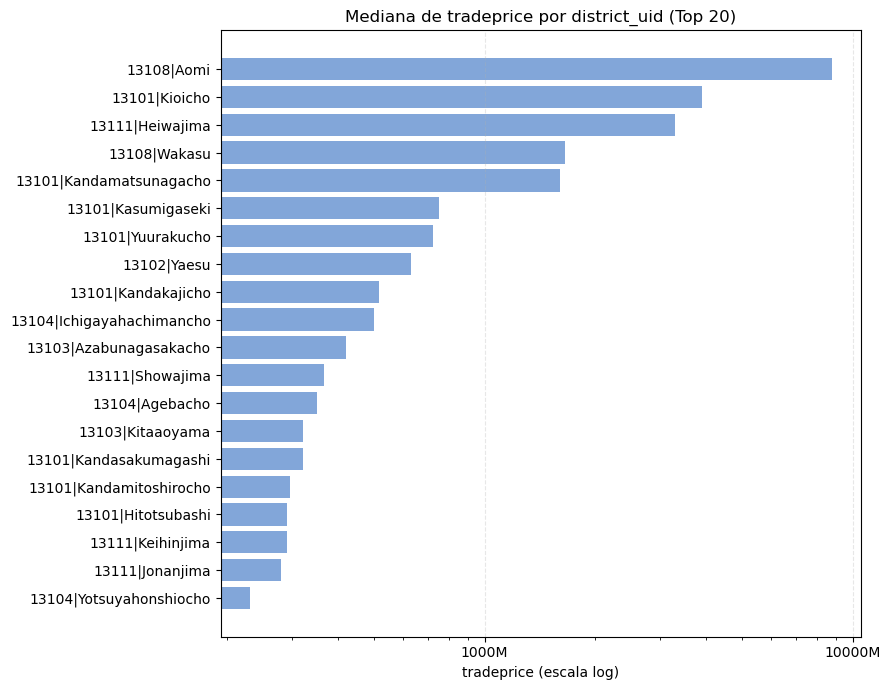

In [292]:
#Ordenando o top 20 pela mediana
top_k = 20
top_uids = summary_med.head(top_k).index

fig, ax = plt.subplots(figsize=(9, 7))
vals = summary_med.loc[top_uids, "median"][::-1]  
ax.barh(top_uids[::-1], vals.values, color="#82A6D9")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e6:.0f}M"))
ax.set_title(f"Mediana de {COL_VALUE} por district_uid (Top {top_k})")
ax.set_xlabel(f"{COL_VALUE} (escala log)")
ax.grid(True, axis="x", ls="--", alpha=.3)
plt.tight_layout()
plt.show()


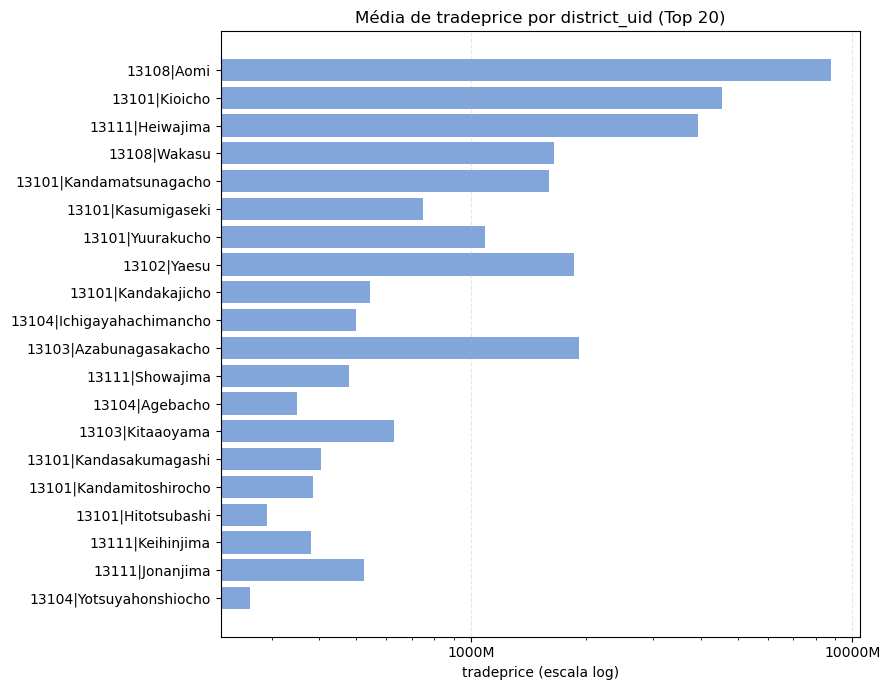

In [329]:
#Ordenando o top 20 pela média
top_k = 20
top_uids = summary_med.head(top_k).index

fig, ax = plt.subplots(figsize=(9, 7))
vals = summary_med.loc[top_uids, "mean"][::-1]  
ax.barh(top_uids[::-1], vals.values, color="#82A6D9")
ax.set_xscale("log")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e6:.0f}M"))
ax.set_title(f"Média de {COL_VALUE} por district_uid (Top {top_k})")
ax.set_xlabel(f"{COL_VALUE} (escala log)")
ax.grid(True, axis="x", ls="--", alpha=.3)
plt.tight_layout()
plt.show()


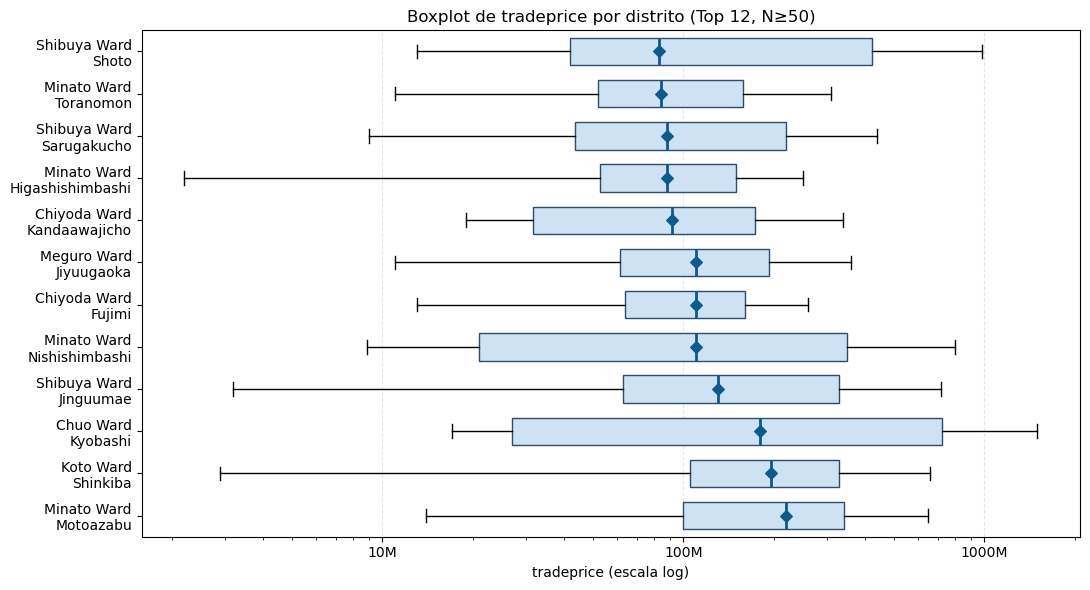

In [310]:
COL_CITY  = "municipality"
COL_DIST  = "districtname"
COL_VALUE = "tradeprice"

# base e id único
X = (df_tratado[[COL_CITY, COL_DIST, COL_VALUE]]
     .dropna()
     .query(f"{COL_VALUE} > 0")
     .copy())
X["district_uid"] = X[COL_CITY].str.strip() + " | " + X[COL_DIST].str.strip()

# agrega e aplica N mínimo
min_n = 50            
top_k = 12            
g = (X.groupby("district_uid")[COL_VALUE]
       .agg(n="size", median="median",
            p25=lambda s: s.quantile(.25), p75=lambda s: s.quantile(.75)))
g = g[g["n"] >= min_n].sort_values("median", ascending=False)
uids = g.head(top_k).index.tolist()

data = [X.loc[X["district_uid"]==u, COL_VALUE].values for u in uids]
data = [v[(v>0) & np.isfinite(v)] for v in data]

def wrap_uid(u, w=22):
    city, dist = [t.strip() for t in u.split("|", 1)]
    city = textwrap.shorten(city, width=w, placeholder="…")
    dist = textwrap.shorten(dist, width=w, placeholder="…")
    return f"{city}\n{dist}"
labels = [wrap_uid(u) for u in uids]

fig, ax = plt.subplots(figsize=(11, 6))
bp = ax.boxplot(
    data,
    vert=False,            # horizontal
    showfliers=False,
    widths=0.65,
    patch_artist=True
)
for b in bp["boxes"]:   b.set(facecolor="#cfe2f3", edgecolor="#2f4b6a")
for m in bp["medians"]: m.set(color="#0e5a8a", linewidth=2)

ax.set_yticks(range(1, len(labels)+1), labels)
ax.set_xscale("log")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1e6:.0f}M"))

ax.set_title(f"Boxplot de {COL_VALUE} por distrito (Top {len(uids)}, N≥{min_n})")
ax.set_xlabel(f"{COL_VALUE} (escala log)")
ax.grid(True, axis="x", ls="--", alpha=.3)

# Se quiser, marque apenas a mediana com um losango (sem texto para não poluir)
meds = [np.median(v) for v in data]
ax.scatter(meds, np.arange(1, len(uids)+1), marker="D", s=35, color="#0e5a8a", zorder=3)

plt.tight_layout()
plt.show()


Entendendo se há correlação entre cidades e tradeprice

In [302]:
groups = [g['tradeprice'].dropna().values
          for _, g in df_tratado.groupby('district_uid') if len(g)>1]

H, p = kruskal(*groups)
k = len(groups); n = sum(len(g) for g in groups)
epsilon2 = (H - k + 1) / (n - k)   # efeito ~ proporção explicada

print(f"Kruskal: H={H:.2f}, p={p:.3g}, ε²={epsilon2:.4f}")

Kruskal: H=56696.49, p=0, ε²=0.1703


In [304]:
cat = "district_uid"
val = "tradeprice"

d = df_tratado[[cat, val]].dropna().copy()

top_k = 12
top_levels = d[cat].value_counts().head(top_k).index
d2 = d[d[cat].isin(top_levels)].copy()

p_mat = sp.posthoc_dunn(d2, val_col=val, group_col=cat, p_adjust='holm')

p_long = (p_mat.reset_index()
          .melt(id_vars='index', var_name='grupo2', value_name='p_adj')
          .rename(columns={'index':'grupo1'}))

p_long = p_long[p_long['grupo1'] < p_long['grupo2']].copy()

med = d2.groupby(cat)[val].median().rename('mediana')
n   = d2.groupby(cat)[val].size().rename('n')
stats = pd.concat([med, n], axis=1)

p_long = (p_long
          .merge(stats, left_on='grupo1', right_index=True)
          .merge(stats, left_on='grupo2', right_index=True, suffixes=('_1','_2')))
p_long['diff_mediana'] = p_long['mediana_1'] - p_long['mediana_2']

def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    # versão eficiente via ordenação
    a_sorted = np.sort(a); b_sorted = np.sort(b)
    import bisect
    greater = sum(len(b_sorted) - np.searchsorted(b_sorted, ai, side='right') for ai in a_sorted)
    less    = sum(np.searchsorted(b_sorted, ai, side='left') for ai in a_sorted)
    delta = (greater - less) / (len(a_sorted)*len(b_sorted))
    return delta

pair_to_delta = {}
for g1, g2 in p_long[['grupo1','grupo2']].itertuples(index=False):
    a = d2.loc[d2[cat]==g1, val].values
    b = d2.loc[d2[cat]==g2, val].values
    pair_to_delta[(g1,g2)] = cliffs_delta(a, b)

p_long['cliffs_delta'] = p_long.apply(lambda r: pair_to_delta[(r['grupo1'], r['grupo2'])], axis=1)

result = p_long.sort_values(['p_adj', 'grupo1', 'grupo2'])

result[['grupo1','grupo2','n_1','n_2','p_adj','diff_mediana','cliffs_delta']].head(20)

,grupo1,grupo2,n_1,n_2,p_adj,diff_mediana,cliffs_delta
84,13102|Kachidoki,13109|Minamioi,912,1177,6.873943e-80,27000000.0,-0.479445
85,13103|Akasaka,13109|Minamioi,1015,1177,1.825186e-75,34000000.0,-0.373470
60,13102|Kachidoki,13108|Kameido,912,1709,2.112388e-58,24000000.0,-0.430011
96,13102|Kachidoki,13109|Nishigotanda,912,1170,6.531035e-57,26000000.0,-0.417889
61,13103|Akasaka,13108|Kameido,1015,1709,5.324106e-54,31000000.0,-0.334933
36,13102|Kachidoki,13104|Nishishinjuku,912,1192,1.144967e-53,26000000.0,-0.363507
97,13103|Akasaka,13109|Nishigotanda,1015,1170,1.355216e-52,33000000.0,-0.347062
37,13103|Akasaka,13104|Nishishinjuku,1015,1192,2.249592e-49,33000000.0,-0.315478
48,13102|Kachidoki,13104|Shinjuku,912,971,1.316207e-47,25000000.0,-0.334353
139,13109|Minamioi,13120|Oizumigakuencho,1177,930,3.312761e-47,-16000000.0,0.439973


### Criando variável de preço por área

In [333]:
cols_req = {"tradeprice","totalfloorarea"}

df_tratado["price_per_sqm"] = df_tratado["tradeprice"] / df_tratado["totalfloorarea"].replace(0, np.nan)

df_tratado.loc[~np.isfinite(df_tratado["price_per_sqm"]) | (df_tratado["price_per_sqm"]<=0), "price_per_sqm"] = np.nan

s = df_tratado["price_per_sqm"].dropna()
print("price_per_sqm  |  n=", len(s))
print(s.describe(percentiles=[.1,.25,.5,.75,.9]).to_string())

price_per_sqm  |  n= 109005
count           109005.0
mean       502039.739703
std        564860.166108
min            18.461538
10%        213333.333333
25%             320000.0
50%        442105.263158
75%             587500.0
90%         756521.73913
max      64444444.444444


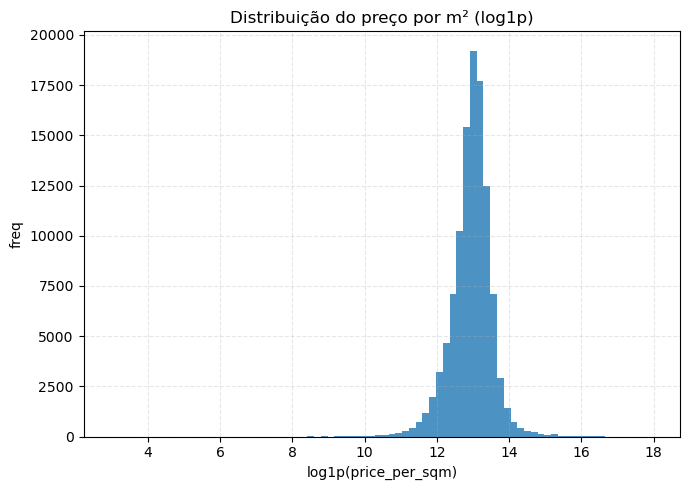

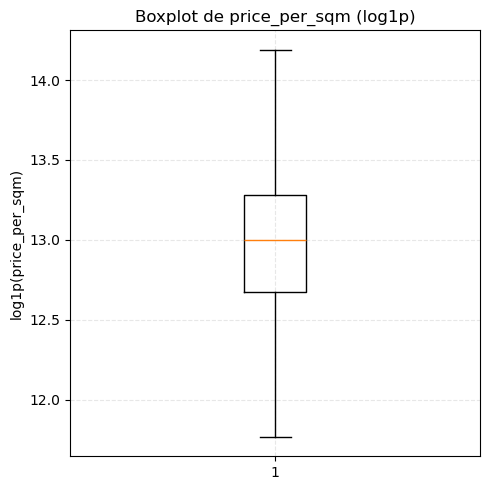

In [335]:
s = df_tratado["price_per_sqm"].dropna()
plt.figure(figsize=(7,5))
plt.hist(np.log1p(s), bins=80, alpha=.8)
plt.xlabel("log1p(price_per_sqm)")
plt.ylabel("freq")
plt.title("Distribuição do preço por m² (log1p)")
plt.grid(True, ls="--", alpha=.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.boxplot(np.log1p(s.values), vert=True, showfliers=False)
plt.ylabel("log1p(price_per_sqm)")
plt.title("Boxplot de price_per_sqm (log1p)")
plt.grid(True, ls="--", alpha=.3)
plt.tight_layout()
plt.show()


In [341]:
num_cols_ext = [
    "minTimetoNearestStation","maxTimetoNearestStation","area","frontage","totalfloorarea",
    "breadth","coverageratio","floorarearatio","tradeprice","time_to_station_mean",
    "year","quarter","price_per_sqm"
]
num_cols_ext = [c for c in num_cols_ext if c in df_tratado.columns]

X = df_tratado[num_cols_ext].copy()
for c in ["tradeprice","area","frontage","totalfloorarea","breadth","coverageratio",
          "floorarearatio","price_per_sqm"]:
    if c in X:
        X[c] = np.log1p(X[c])

corr_spr = X.corr(method="spearman")
print("Correlação (Spearman) de log1p(price_per_sqm) com variáveis selecionadas:")
print(corr_spr["price_per_sqm"].sort_values(ascending=False).to_string())


Correlação (Spearman) de log1p(price_per_sqm) com variáveis selecionadas:
price_per_sqm           1.000000
tradeprice              0.663420
floorarearatio          0.082027
coverageratio           0.078119
year                    0.010584
quarter                -0.004320
totalfloorarea         -0.037213
breadth                -0.053192
frontage               -0.068293
area                   -0.082232
time_to_station_mean   -0.281378


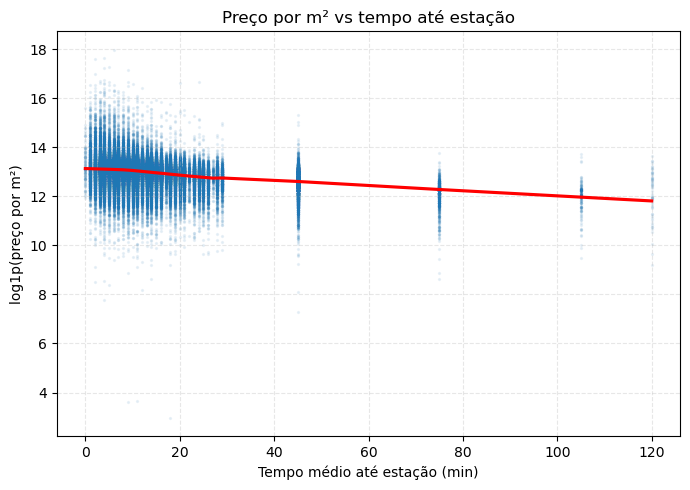

In [339]:
d = df_tratado[["time_to_station_mean","price_per_sqm"]].dropna().copy()
d = d[d["price_per_sqm"]>0]

plt.figure(figsize=(7,5))
sns.regplot(x="time_to_station_mean",
            y=np.log1p(d["price_per_sqm"]),
            data=d, lowess=True, scatter_kws={"s":2, "alpha":.08}, line_kws={"color":"red"})
plt.xlabel("Tempo médio até estação (min)")
plt.ylabel("log1p(preço por m²)")
plt.title("Preço por m² vs tempo até estação")
plt.grid(True, ls="--", alpha=.3)
plt.tight_layout()
plt.show()


Podemos ver claramente uma tendência que mostra que conforme a residência vai se afastando da estação, o seu preço tende a diminuir

In [354]:
groups = [g['price_per_sqm'].dropna().values
          for _, g in df_tratado.groupby('region') if len(g)>1]

H, p = kruskal(*groups)
k = len(groups); n = sum(len(g) for g in groups)
epsilon2 = (H - k + 1) / (n - k)   # efeito ~ proporção explicada

print(f"Kruskal: H={H:.2f}, p={p:.3g}, ε²={epsilon2:.4f}")

Kruskal: H=273.64, p=5.05e-59, ε²=0.0025


In [356]:
cat = "region"
val = "price_per_sqm"

d = df_tratado[[cat, val]].dropna().copy()

top_k = 12
top_levels = d[cat].value_counts().head(top_k).index
d2 = d[d[cat].isin(top_levels)].copy()

p_mat = sp.posthoc_dunn(d2, val_col=val, group_col=cat, p_adjust='holm')

p_long = (p_mat.reset_index()
          .melt(id_vars='index', var_name='grupo2', value_name='p_adj')
          .rename(columns={'index':'grupo1'}))

p_long = p_long[p_long['grupo1'] < p_long['grupo2']].copy()

med = d2.groupby(cat)[val].median().rename('mediana')
n   = d2.groupby(cat)[val].size().rename('n')
stats = pd.concat([med, n], axis=1)

p_long = (p_long
          .merge(stats, left_on='grupo1', right_index=True)
          .merge(stats, left_on='grupo2', right_index=True, suffixes=('_1','_2')))
p_long['diff_mediana'] = p_long['mediana_1'] - p_long['mediana_2']

def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    a_sorted = np.sort(a); b_sorted = np.sort(b)
    import bisect
    greater = sum(len(b_sorted) - np.searchsorted(b_sorted, ai, side='right') for ai in a_sorted)
    less    = sum(np.searchsorted(b_sorted, ai, side='left') for ai in a_sorted)
    delta = (greater - less) / (len(a_sorted)*len(b_sorted))
    return delta

pair_to_delta = {}
for g1, g2 in p_long[['grupo1','grupo2']].itertuples(index=False):
    a = d2.loc[d2[cat]==g1, val].values
    b = d2.loc[d2[cat]==g2, val].values
    pair_to_delta[(g1,g2)] = cliffs_delta(a, b)

p_long['cliffs_delta'] = p_long.apply(lambda r: pair_to_delta[(r['grupo1'], r['grupo2'])], axis=1)

result = p_long.sort_values(['p_adj', 'grupo1', 'grupo2'])

result[['grupo1','grupo2','n_1','n_2','p_adj','diff_mediana','cliffs_delta']].head(20)

,grupo1,grupo2,n_1,n_2,p_adj,diff_mediana,cliffs_delta
4,Commercial Area,Industrial Area,11276,562,1.457383e-45,142739.89899,-0.314600
13,Industrial Area,Residential Area,562,97162,1.040152e-32,-130299.707602,0.299068
12,Commercial Area,Residential Area,11276,97162,5.866534e-27,12440.191388,-0.062721
9,Industrial Area,Potential Residential Area,562,5,6.622761e-03,-538194.444444,0.466192
8,Commercial Area,Potential Residential Area,11276,5,1.059823e-01,-395454.545455,0.358230
14,Potential Residential Area,Residential Area,5,97162,1.059823e-01,407894.736842,-0.510675


C:\Users\cicer\AppData\Local\Temp\ipykernel_77868\3761979691.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


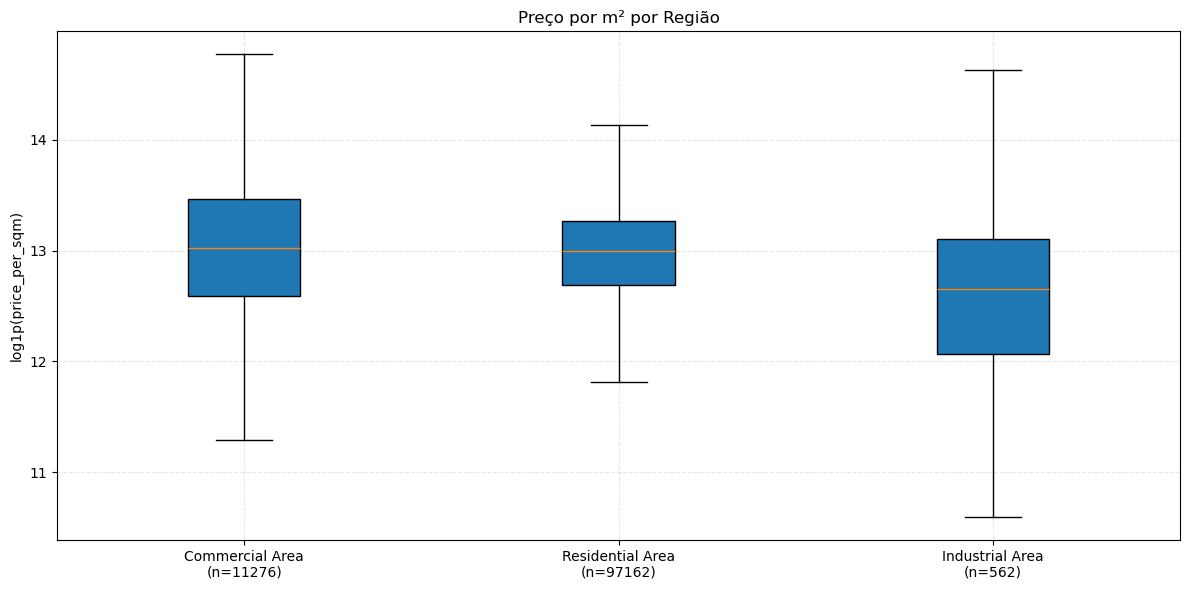

C:\Users\cicer\AppData\Local\Temp\ipykernel_77868\3761979691.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


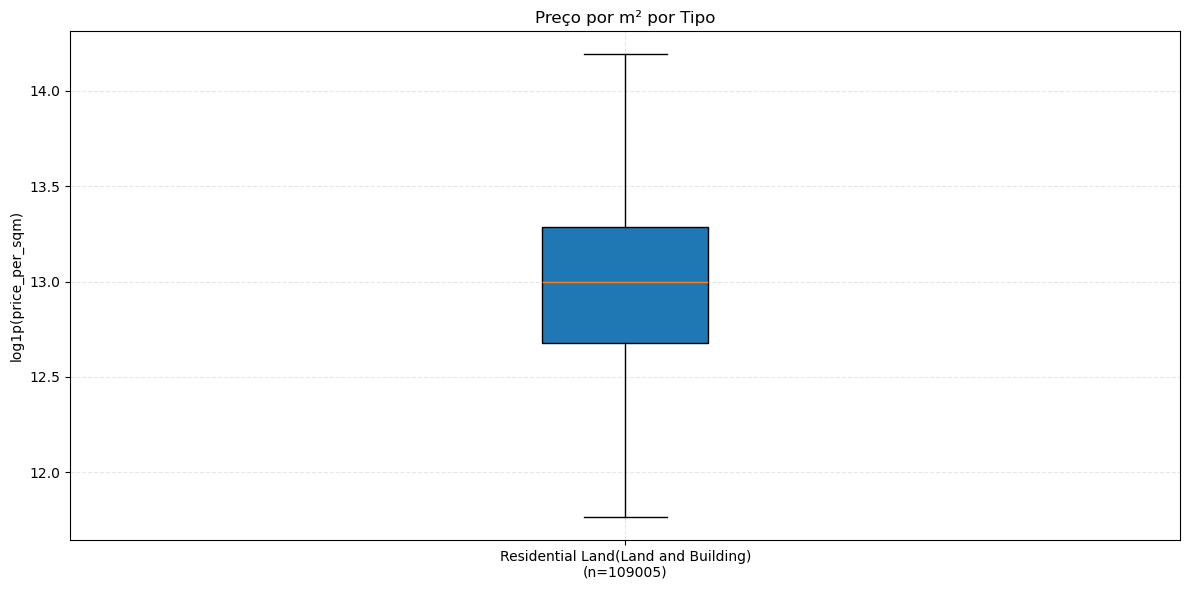

In [358]:
def boxplot_ordered(df, cat, val, top_k=12, min_n=50, title=None):
    d = df[[cat, val]].dropna().copy()
    counts = d[cat].value_counts()
    keep = counts[counts>=min_n].head(top_k).index
    d = d[d[cat].isin(keep)].copy()

    order = (d.groupby(cat)[val].median()
               .sort_values(ascending=False)
               .index.tolist())

    data = [np.log1p(d.loc[d[cat]==c, val].values) for c in order]
    labels = [f"{c}\n(n={len(d.loc[d[cat]==c])})" for c in order]

    import matplotlib.ticker as mtick
    fig, ax = plt.subplots(figsize=(12,6))
    ax.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
    ax.set_ylabel("log1p(price_per_sqm)")
    ax.set_title(title or f"Boxplot de price_per_sqm por {cat} (top {top_k}, sem outliers)")
    ax.grid(True, ls="--", alpha=.3)
    plt.xticks(rotation=0, ha="center")
    plt.tight_layout()
    plt.show()

boxplot_ordered(df_tratado, "region", "price_per_sqm", top_k=12, title="Preço por m² por Região")
boxplot_ordered(df_tratado, "type",   "price_per_sqm", top_k=12, title="Preço por m² por Tipo")


In [360]:
pivot_med = (df_tratado[["type","region","price_per_sqm"]]
             .dropna()
             .groupby(["type","region"])["price_per_sqm"]
             .median()
             .unstack("region")
             .sort_index())
pd.options.display.float_format = "{:,.0f}".format
pivot_med


region,Commercial Area,Industrial Area,Potential Residential Area,Residential Area
type,,,,
Residential Land(Land and Building),"454,545","311,806","850,000","442,105"


### Analise temporal

In [363]:
df_tmp = df_tratado.copy()

df_tmp["yq"] = pd.PeriodIndex(
    year=df_tmp["year"], quarter=df_tmp["quarter"], freq="Q"
).to_timestamp(how="end")

df_tmp["log_price"] = np.log1p(df_tmp["tradeprice"])

C:\Users\cicer\AppData\Local\Temp\ipykernel_77868\3863614448.py:3: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df_tmp["yq"] = pd.PeriodIndex(


In [365]:
MIN_N_PER_POINT = 100   
TOP_REGIONS = 6    

# agrega por região × trimestre
g = (df_tmp.groupby(["region","yq"])["log_price"]
         .agg(mediana="median", n="size")
         .reset_index())

# filtra pontos com amostra mínima
g_f = g[g["n"] >= MIN_N_PER_POINT].copy()

# escolhe as regiões mais frequentes para o gráfico
top_regions = (df_tmp.groupby("region").size()
               .sort_values(ascending=False).head(TOP_REGIONS).index)

piv = (g_f[g_f["region"].isin(top_regions)]
       .pivot(index="yq", columns="region", values="mediana")
       .sort_index())


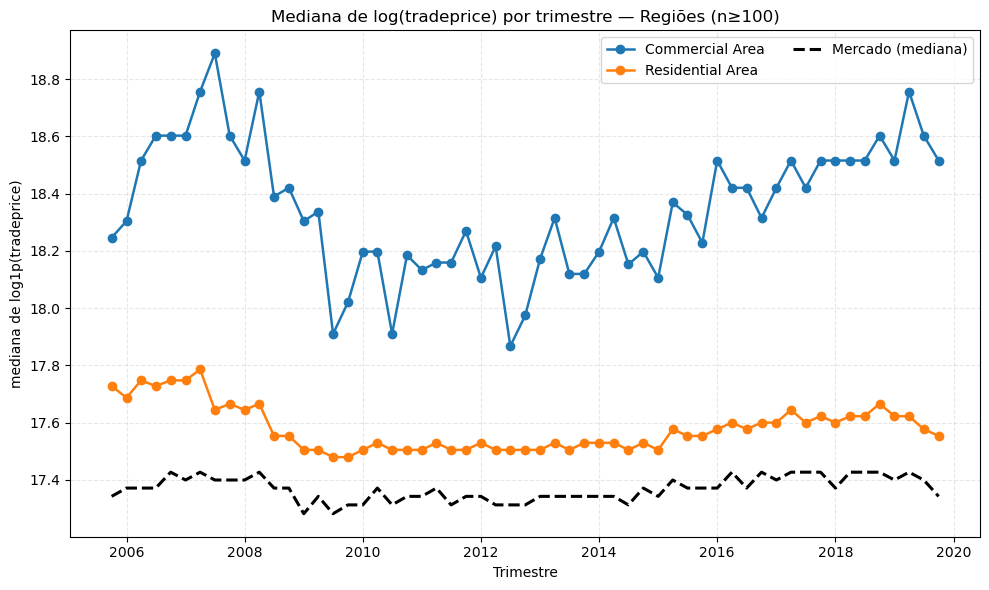

In [367]:
plt.figure(figsize=(10,6))
for col in piv.columns:
    plt.plot(piv.index, piv[col], marker="o", linewidth=1.8, label=col)

# linha do "mercado" (mediana global por trimestre)
mkt = (df_tmp.groupby("yq")["log_price"].median().sort_index())
plt.plot(mkt.index, mkt.values, linestyle="--", linewidth=2.2, color="black", label="Mercado (mediana)")

plt.title(f"Mediana de log(tradeprice) por trimestre — Regiões (n≥{MIN_N_PER_POINT})")
plt.xlabel("Trimestre"); plt.ylabel("mediana de log1p(tradeprice)")
plt.grid(True, ls="--", alpha=.3); plt.legend(ncol=2)
plt.tight_layout(); plt.show()


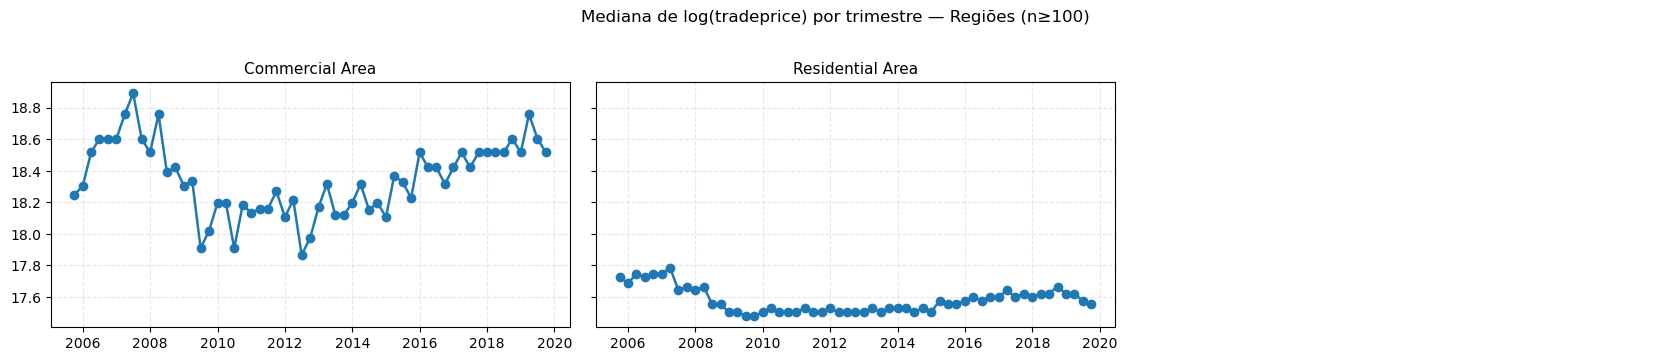

In [369]:
n = len(piv.columns)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5.6*ncols, 3.6*nrows), sharex=True, sharey=True)
axes = axes.ravel()

for ax, col in zip(axes, piv.columns):
    ax.plot(piv.index, piv[col], marker="o", linewidth=1.8)
    ax.set_title(col, fontsize=11)
    ax.grid(True, ls="--", alpha=.3)

for ax in axes[n:]: ax.axis("off")

fig.suptitle(f"Mediana de log(tradeprice) por trimestre — Regiões (n≥{MIN_N_PER_POINT})", y=0.99)
plt.tight_layout(rect=[0,0,1,0.97]); plt.show()


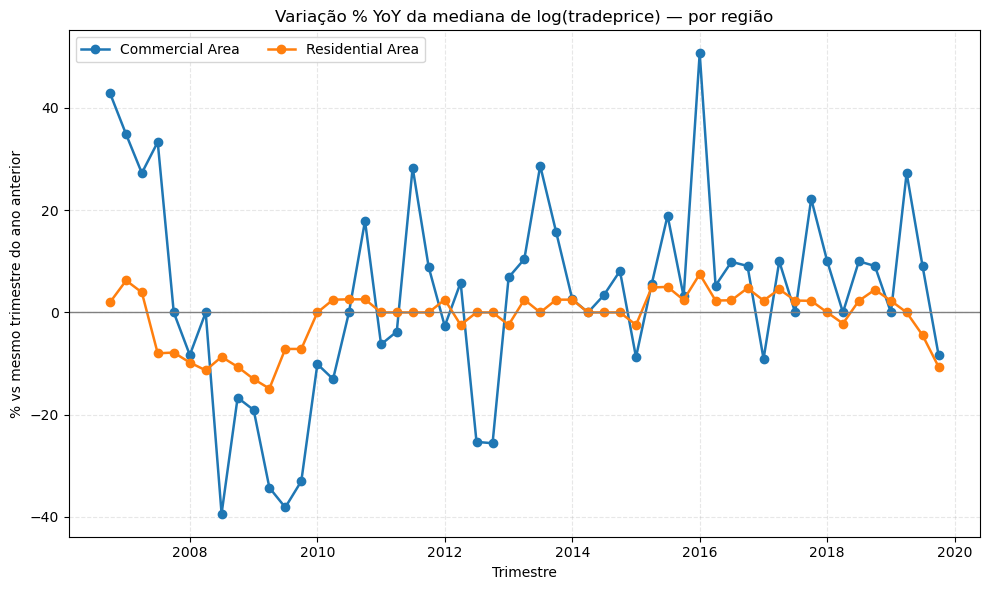

In [381]:
g_f = g_f.sort_values(['region','yq']).copy()

# diferença de 4 trimestres (YoY) sobre a mediana do log
g_f['delta_log'] = g_f.groupby('region')['mediana'].diff(4)

# converte p/ % (aproximado): exp(delta_log) - 1
g_yoy = g_f[['region','yq','delta_log']].dropna().copy()
g_yoy['yoy_pct'] = np.expm1(g_yoy['delta_log']) * 100

plot_yoy = g_yoy[g_yoy['region'].isin(top_regions)].pivot(index='yq', columns='region', values='yoy_pct')

plt.figure(figsize=(10,6))
for col in plot_yoy.columns:
    plt.plot(plot_yoy.index, plot_yoy[col], marker='o', linewidth=1.8, label=col)
plt.axhline(0, color='gray', lw=1)
plt.title("Variação % YoY da mediana de log(tradeprice) — por região")
plt.ylabel("% vs mesmo trimestre do ano anterior")
plt.xlabel("Trimestre")
plt.grid(True, ls="--", alpha=.3); plt.legend(ncol=2)
plt.tight_layout(); plt.show()


# Insights baseados nas análises

- Área é o principal influênciador do preço: relação positiva e forte.
- Existem diferênças grandes de preço entre cidades e, principalmente, entre distritos
- A região impacta o preço, mas menos do que cidade e bairro
- Quanto mais perto da estação, maior o preço por m²
- Temos diferenças de preço entre os tipos de imóveis. Usos comerciais/industriais concentram transações de ticket mais alto; áreas “potencialmente residenciais” ficam abaixo das residenciais consolidadas. 
- Dentro de uma mesma cidade, há forte dispersão por distrito, ou seja, o bairro importa no preço